In [1]:
### import pandas as pd
from src.core.pivot_handler import PivotHandler
from src.core.segmentation_handler import CumulativeSegmentsSplitter
from src.models.models import get_data
from src.core.segmentation_handler import SegmentationHandler
from src.core.hypothesis_evaluation.test_evaluation import StatisticalTestHandler
from src.utils.tools import update_column_names,experiment_name,extract_experiment_name,find_query_name
from datetime import datetime
from statsmodels.stats.multitest import multipletests
import numpy as np
import matplotlib.pyplot as plt
from src.core.budget_evaluation import compute_result_budget
from utils.results import iterate_in_results
from src.core.hypothesis_evaluation.test_handler import run_tests_for
from src.core.hypothesis_evaluation.explore_results import get_plot_data,generate_stats,plot_result,generate_plot_data
from itertools import product
from scipy import stats
import datetime
import pandas as pd 
error_arg = "fdr_by"
corrected_err_column = f"p-value {error_arg}"


def extract_name(x):
    pivot = x["pivot"].replace("Retail_","").split()[0]
    segmentation = x["segmentation"].replace("Retail_","").replace("Amazon_","").split()[0]
    return find_query_name(pivot,segmentation)


from statsmodels.stats.multitest import multipletests
import numpy as np
import matplotlib.pyplot as plt

def fix_legend(ax,title="Segmentations",position=3):
    ax.legend(loc=position,title=title,borderpad=0, labelspacing=0,markerscale=6,handletextpad=-0.5)

    # Legend edit 
    legend = ax.get_legend()    
    legend.get_title().set_position((0, 50)) # -10 is a guess
    legend.get_frame().set_linewidth(3)
    legend.get_frame().set_edgecolor("black")
    
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaller = MinMaxScaler()

independence_test_threshold = 0.05

error_arg = "fdr_by"

alpha = 0.05
approach = 1

In [2]:
data  = generate_stats(avoid_filter="",files_filter="",approach=1,alpha=0.05)
data2 = generate_stats(avoid_filter="",files_filter="",approach=1,alpha=0.01)
pd.concat([data,data2]).sort_values("#results")

#(h,e)   #e    #h  \
dataset         query# pivot           segmentation alpha                      
Amazon          #Q12   Promotion       Trend        0.05     1012   22    46   
Tafeng          #Q10   Demographics    Trend        0.01     3779   62    61   
Sales           #Q12   Promotion       Trend        0.01     5680   71    80   
                                                    0.01    17112   92   186   
RetailPromotion #Q12   RetailPromotion Trend        0.01    22748   96   245   
...                                                           ...  ...   ...   
Amazon          #Q3    Promotion       PWindow_1K   0.05    78076  131   596   
                                       PWindow_500  0.01   310851  261  1191   
                                                    0.01   310851  261  1191   
                                                    0.05   310851  261  1191   
                                                    0.05   310851  261  1191   

                                                           #results  \
dataset         query# pivot           segmentation alpha             
Amazon          #Q12   Promotion       Trend        0.05          0   
Tafeng          #Q10   Demographics    Trend        0.01          0   
Sales           #Q12   Promotion       Trend        0.01          0   
                                                    0.01          0   
RetailPromotion #Q12   RetailPromotion Trend        0.01          0   
...                                                             ...   
Amazon          #Q3    Promotion       PWindow_1K   0.05       9071   
                                       PWindow_500  0.01      61365   
                                                    0.01      61365   
                                                    0.05      61878   
                                                    0.05      61878   

                                                           #result(Bonferoni)  \
dataset         query# pivot           segmentation alpha                       
Amazon          #Q12   Promotion       Trend        0.05                    0   
Tafeng          #Q10   Demographics    Trend        0.01                    0   
Sales           #Q12   Promotion       Trend        0.01                    0   
                                                    0.01                    0   
RetailPromotion #Q12   RetailPromotion Trend        0.01                    0   
...                                                                       ...   
Amazon          #Q3    Promotion       PWindow_1K   0.05                 8955   
                                       PWindow_500  0.01                58456   
                                                    0.01                58456   
                                                    0.05                58929   
                                                    0.05                58929   

                                                           coverage  \
dataset         query# pivot           segmentation alpha             
Amazon          #Q12   Promotion       Trend        0.05          0   
Tafeng          #Q10   Demographics    Trend        0.01          0   
Sales           #Q12   Promotion       Trend        0.01          0   
                                                    0.01          0   
RetailPromotion #Q12   RetailPromotion Trend        0.01          0   
...                                                             ...   
Amazon          #Q3    Promotion       PWindow_1K   0.05      77463   
                                       PWindow_500  0.01     310013   
                                                    0.01     310013   
                                                    0.05     310013   
                                                    0.05     310013   

                                                                   min-p  \
dataset         query# pivot           s

In [4]:
!pip install tabulate

You should consider upgrading via the '/home/abdelouahab/.virtualenvs/SSQ/bin/python -m pip install --upgrade pip' command.


In [13]:
text = pd.concat([data,data2]).sort_values("#results").reset_index().drop(["file","z_test"],axis=1).tail(50).to_markdown(index=None)
print(text)

| dataset   | query#   | pivot        | segmentation                   |   alpha |   #(h,e) |   #e |   #h |   #results |   #result(Bonferoni) |   coverage |        min-p |       budget |
|:----------|:---------|:-------------|:-------------------------------|--------:|---------:|-----:|-----:|-----------:|---------------------:|-----------:|-------------:|-------------:|
| Tafeng    | #Q3      | Promotion    | PWindow_2K                     |    0.05 |    27940 |  117 |  294 |          0 |                    0 |          0 | 1            |  0           |
| Tafeng    | #Q3      | Promotion    | PWindow_30K                    |    0.05 |      151 |    8 |   20 |          0 |                    0 |          0 | 1            |  0           |
| Tafeng    | #Q3      | Promotion    | PWindow_35K                    |    0.05 |      103 |    7 |   17 |          0 |                    0 |          0 | 1            |  0           |
| Tafeng    | #Q3      | Promotion    | TWindow_3W               

In [3]:
pd.concat([data]).sort_values("#results").iloc[-2].file

"experiments/results/Tafeng_pivot: Demographics ['age_range2'] , segmentation: Window 30000.csv"

In [4]:
files = ["experiments/results/Tafeng_pivot: Demographics ['age_range2'] , segmentation: Window 30000.csv"]
data = get_plot_data(files,
                     approach=approach,
                     alpha=alpha
                    )
data

,p-value fdr_by,budget,coverage (#results),#results,coverage (size),budget (NN),e,h,pivot,segmentation,alpha,factor,approach
64,0.001797,1.000000,0.111111,1,0.121821,0.215284,2000-12-18,2001-02-01,Tafeng_Demographics ['age_range2'],Window 30000,0.05,1,p-value-based
9,0.001797,0.991652,0.222222,2,0.243642,0.213487,2000-11-04,2001-01-01,Tafeng_Demographics ['age_range2'],Window 30000,0.05,1,p-value-based
60,0.009385,0.948060,0.333333,3,0.243642,0.204102,2000-12-18,2000-11-01,Tafeng_Demographics ['age_range2'],Window 30000,0.05,1,p-value-based
61,0.014089,0.882616,0.444444,4,0.243642,0.190013,2000-12-18,2000-11-22,Tafeng_Demographics ['age_range2'],Window 30000,0.05,1,p-value-based
3,0.020705,0.786441,0.555556,5,0.266140,0.169308,2000-11-01,2001-01-01,Tafeng_Demographics ['age_range2'],Window 30000,0.05,1,p-value-based
123,0.035815,0.620079,0.666667,6,0.288638,0.133493,2001-02-16,2001-01-01,Tafeng_Demographics ['age_range2'],Window 30000,0.05,1,p-value-based
8,0.044498,0.413386,0.777778,7,0.288638,0.088995,2000-11-04,2000-12-14,Tafeng_Demographics ['age_range2'],Window 30000,0.05,1,p-value-based
75,0.044498,0.206693,0.888889,8,0.311137,0.044498,2001-01-01,2001-01-01,Tafeng_Demographics ['age_range2'],Window 30000,0.05,1,p-value-based
27,0.044498,0.000000,1.000000,9,0.333635,0.000000,2000-11-19,2001-01-01,Tafeng_Demographics ['age_range2'],Window 30000,0.05,1,p-value-based


In [6]:
users = []
for i in data.h.unique():
    users.append(dataset.loc[i:].iloc[:30000].cust_id.unique())

In [5]:
dataset = get_data(dataset="Tafeng")

In [17]:
dataset.cust_id.nunique()

32266

In [7]:
sub = dataset[dataset.age.isin(data.h.unique())]
sub.cust_id.nunique()

0

In [ ]:
dataset.loc["2000-11-01":]

In [8]:
customers = pd.DataFrame(users).sum().unique()

In [18]:
sub_df = dataset[dataset.cust_id.isin(customers)]
result = sub_df.groupby(["age",pd.Grouper(freq="W")]).amount.sum().reset_index()

In [36]:
from scipy import stats

result.groupby("age").amount.apply(list).apply(lambda x : stats.ttest_1samp(x, 150)[1]/2<0.05)

age
25-29     True
30-34     True
35-39    False
40-44     True
45-49    False
50-54     True
55-59     True
60-64     True
<25       True
>65       True
Name: amount, dtype: bool

In [34]:
data

age
25-29     44.666667
30-34    110.666667
35-39    135.333333
40-44    125.888889
45-49    136.722222
50-54     36.470588
55-59     41.944444
60-64     37.277778
<25       46.555556
>65       31.000000
Name: amount, dtype: float64

###  Data for plots 

In [3]:
data = get_plot_data(files,approach=approach,alpha=alpha)
data["pivot"].unique(),data["segmentation"].unique()

NameError: name 'files' is not defined

In [7]:
a=!ls experiments/results/Amazon*Promotion*Window*
files = [i for i in a if "zt" not in i and  ("500.csv" in i or "10000" in i )and '2017-01-01' in i   ]
files

["experiments/results/Amazon_pivot: Promotion ['2016-11-20', '2017-01-01'] , segmentation: Window 10000.csv",
 "experiments/results/Amazon_pivot: Promotion ['2016-11-20', '2017-01-01'] , segmentation: Window 500.csv"]

In [8]:
### Plot 5
a=!ls experiments/results/Amazon*Promotion*Window*
files = [i for i in a if "zt" not in i and  ("500" in i or "10000" in i )and '2017-01-01' in i  ]
files = [i for i in a if "zt" not in i and  ("500.csv" in i or "10000" in i )and '2017-01-01' in i   ]
files


alpha = 0.05
plot_data = get_plot_data(files,approach=approach,alpha=alpha)
approach = 1
groupby_columns = ["alpha","pivot","segmentation"]
plot_index = "coverage (size)"

pivots = [
    "Amazon_Promotion ['2016-11-20', '2017-01-01']",
#     "Retail_Demographics ['gender']",
]
segmentations = [
#     "Demographics location, gender",
#     "Demographics location",
#     "Demographics gender"
#     "Window 1K",
    "Window 10K",
    "Window 500",
#     "Window 2K",
]
df_result = pd.DataFrame()
for approach in [1,2]:
    for alpha in [0.01,0.05]:
        for pivot in pivots:
            data = get_plot_data(files,approach=approach,alpha=alpha)
            data = data[(data.segmentation.isin(segmentations))&(data["pivot"].isin(pivots))]
            df_result = pd.concat([df_result,data])

In [9]:
def extract_name(x):
    pivot = x["pivot"].replace("Retail_","").replace("Amazon_","").split()[0]
    segmentation = x["segmentation"].replace("Retail_","").replace("Amazon_","").split()[0]
    return find_query_name(pivot,segmentation)
df_result["query"] = df_result.apply(lambda x :extract_name(x),axis=1)
df_result.loc[df_result.drop_duplicates("query").index].replace(',',"")

,p-value fdr_by,budget,coverage (#results),#results,coverage (size),budget (NN),e,h,pivot,segmentation,alpha,factor,approach,query
372,8.361427e-190,1.0,0.001312,1,0.046836,0.082755,article_id cust_id ...,article_id cust_id ...,"Amazon_Promotion ['2016-11-20', '2017-01-01']",Window 10K,0.01,1,p-value-based,#Q3
372,5.748232e-14,1.0,0.603920,152619,0.010378,47.690869,2017-01-01,2015-09-25,"Amazon_Promotion ['2016-11-20', '2017-01-01']",Window 500,0.01,1,p-value-based,#Q3
372,8.361427e-190,1.0,0.001295,1,0.046836,0.322725,article_id cust_id ...,article_id cust_id ...,"Amazon_Promotion ['2016-11-20', '2017-01-01']",Window 10K,0.05,1,p-value-based,#Q3
372,5.748232e-14,1.0,0.580243,152619,0.010378,370.705177,2017-01-01,2015-09-25,"Amazon_Promotion ['2016-11-20', '2017-01-01']",Window 500,0.05,1,p-value-based,#Q3
372,8.361427e-190,1.0,0.001312,1,0.046836,0.082755,article_id cust_id ...,article_id cust_id ...,"Amazon_Promotion ['2016-11-20', '2017-01-01']",Window 10K,0.01,1,coverage-based,#Q3
372,5.748232e-14,1.0,0.603457,152502,0.010029,47.690869,2017-01-01,2015-09-25,"Amazon_Promotion ['2016-11-20', '2017-01-01']",Window 500,0.01,1,coverage-based,#Q3
372,8.361427e-190,1.0,0.001295,1,0.046836,0.322725,article_id cust_id ...,article_id cust_id ...,"Amazon_Promotion ['2016-11-20', '2017-01-01']",Window 10K,0.05,1,coverage-based,#Q3
372,5.748232e-14,1.0,0.579798,152502,0.010029,370.705177,2017-01-01,2015-09-25,"Amazon_Promotion ['2016-11-20', '2017-01-01']",Window 500,0.05,1,coverage-based,#Q3


In [10]:
df_result["segmentation"] = df_result["segmentation"].apply(lambda x : x.replace(",","_"))
df_result["pivot"] = df_result["pivot"].apply(lambda x : x.replace(",",""))

In [11]:
for _,i in df_result.rename(columns={"budget":"Risk Capital Normalized","budget (NN)":"Risk Capital"}).groupby(["alpha","approach","pivot","segmentation"]):
    i.drop("factor",axis=1).to_csv(f"{'_'.join(str(i) for i in _)}.csv")
    print(f"{'_'.join(str(i) for i in _)}.csv")



0.01_coverage-based_Amazon_Promotion ['2016-11-20' '2017-01-01']_Window 10K.csv
0.01_coverage-based_Amazon_Promotion ['2016-11-20' '2017-01-01']_Window 500.csv
0.01_p-value-based_Amazon_Promotion ['2016-11-20' '2017-01-01']_Window 10K.csv
0.01_p-value-based_Amazon_Promotion ['2016-11-20' '2017-01-01']_Window 500.csv
0.05_coverage-based_Amazon_Promotion ['2016-11-20' '2017-01-01']_Window 10K.csv
0.05_coverage-based_Amazon_Promotion ['2016-11-20' '2017-01-01']_Window 500.csv
0.05_p-value-based_Amazon_Promotion ['2016-11-20' '2017-01-01']_Window 10K.csv
0.05_p-value-based_Amazon_Promotion ['2016-11-20' '2017-01-01']_Window 500.csv


In [17]:
(df_result.rename(columns={"budget":"Risk Capital Normalized","budget (NN)":"Risk Capital"})
 .drop("factor",axis=1)
 .groupby(["alpha","approach","pivot","segmentation"])["coverage (size)"].max().to_frame()
 .to_csv("aggregated_data_figure_5_6.csv")
)

#(h,e)   #e    #h  #results  \
dataset query# pivot     segmentation alpha                                
Amazon  #Q12   Promotion Trend        0.01     1012   22    46         0   
        #Q3    Promotion PWindow_10K  0.01      840   14    60        24   
                         PWindow_500  0.01   310851  261  1191     61365   
                         PWindow_5K   0.01     3240   27   120        50   
Retail  #Q12   Promotion Trend        0.01      864   48    18         0   
                                      0.01     3705   40    95         0   
Amazon  #Q12   Promotion Trend        0.05     1012   22    46         0   
        #Q3    Promotion PWindow_10K  0.05      840   14    60        24   
                         PWindow_500  0.05   310851  261  1191     61878   
                         PWindow_5K   0.05     3240   27   120        50   
Retail  #Q12   Promotion Trend        0.05      864   48    18         0   
                                      0.05     3705   40    95         0   

                                             #result(Bonferoni)  coverage  \
dataset query# pivot     segmentation alpha                                 
Amazon  #Q12   Promotion Trend        0.01                    0         0   
        #Q3    Promotion PWindow_10K  0.01                   24       778   
                         PWindow_500  0.01                58456    310013   
                         PWindow_5K   0.01                   49      3116   
Retail  #Q12   Promotion Trend        0.01                    0         0   
                                      0.01                    0         0   
Amazon  #Q12   Promotion Trend        0.05                    0         0   
        #Q3    Promotion PWindow_10K  0.05                   24       778   
                         PWindow_500  0.05                58929    310013   
                         PWindow_5K   0.05                   49      3116   
Retail  #Q12   Promotion Trend        0.05                    0         0   
                                      0.05                    0         0   

                                                     min-p     budget  z_test  
dataset query# pivot     segmentation alpha                                    
Amazon  #Q12   Promotion Trend        0.01    1.000000e+00   0.000000    True  
        #Q3    Promotion PWindow_10K  0.01   1.290909e-175   0.000088    True  
                         PWindow_500  0.01   6.137338e-118   3.093316    True  
                         PWindow_5K   0.01   6.135787e-202   0.008073    True  
Retail  #Q12   Promotion Trend        0.01    1.000000e+00   0.000000    True  
                                      0.01    1.000000e+00   0.000000    True  
Amazon  #Q12   Promotion Trend        0.05    1.000000e+00   0.000000    True  
        #Q3    Promotion PWindow_10K  0.05   1.290909e-175   0.000088    True  
                         PWindow_500  0.05   6.137338e-118  15.393474    True  
                         PWindow_5K   0.05   6.135787e-202   0.008073    True  
Retail  #Q12   Promotion Trend        0.05    1.000000e+00   0.000000    True  
                                      0.05    1.000000e+00   0.000000    True

##### Showing histograms

In [6]:

def plot_hist(pivot,segmentations,groupby_columns,plot_index,approach,alpha,position=3,remove_legend=False):
    plot_data = get_plot_data(files,approach=approach,alpha=alpha)
    index = (plot_data.segmentation.isin(segmentations)) &( plot_data["pivot"].isin(pivot) )
    data = plot_data[index]
    data = data.groupby(groupby_columns)[plot_index].max().reset_index()
    data = data.pivot(index="pivot",columns="segmentation",values=plot_index)
    ax = data.plot(kind='bar',figsize=(20,10))
    def fix_legend(ax,title="Segmentations",position=3):
        ax.legend(loc=position,title=title,borderpad=0, labelspacing=0,markerscale=4,handletextpad=0,prop={'size': 40})

        # Legend edit 
        legend = ax.get_legend()    
        legend.get_title().set_position((-150, 50)) # -10 is a guess
        legend.get_frame().set_linewidth(2)
        legend.get_frame().set_edgecolor("black")

    fix_legend(ax,position=position)
    if remove_legend:
        ax.get_legend().remove()
    ax.axes.get_xaxis().set_visible(False)

In [16]:
files = !ls experiments/results/*.csv
plot_data = get_plot_data(files,approach=approach,alpha=alpha)

index 0 is out of bounds for axis 0 with size 0
experiments/results/Retail_pivot: Demographics ['gender'] , segmentation: Demographics ['gender'].csv
index 0 is out of bounds for axis 0 with size 0
experiments/results/Retail_pivot: Demographics ['gender'] , segmentation: None .csv
'<=' not supported between instances of 'str' and 'float'
experiments/results/Retail_pivot: None [10] , segmentation: Demographics ['location'].csv
index 0 is out of bounds for axis 0 with size 0
experiments/results/Retail_pivot: None [10] , segmentation: Window 2000.csv
index 0 is out of bounds for axis 0 with size 0
experiments/results/Tafeng_pivot: Trend ['Up', 'Down'] , segmentation: Window 28D.csv


index 0 is out of bounds for axis 0 with size 0
experiments/results/Retail_pivot: Demographics ['gender'] , segmentation: Demographics ['gender'].csv
index 0 is out of bounds for axis 0 with size 0
experiments/results/Retail_pivot: Demographics ['gender'] , segmentation: None .csv
'<=' not supported between instances of 'str' and 'float'
experiments/results/Retail_pivot: None [10] , segmentation: Demographics ['location'].csv
index 0 is out of bounds for axis 0 with size 0
experiments/results/Retail_pivot: None [10] , segmentation: Window 2000.csv
index 0 is out of bounds for axis 0 with size 0
experiments/results/Tafeng_pivot: Trend ['Up', 'Down'] , segmentation: Window 28D.csv


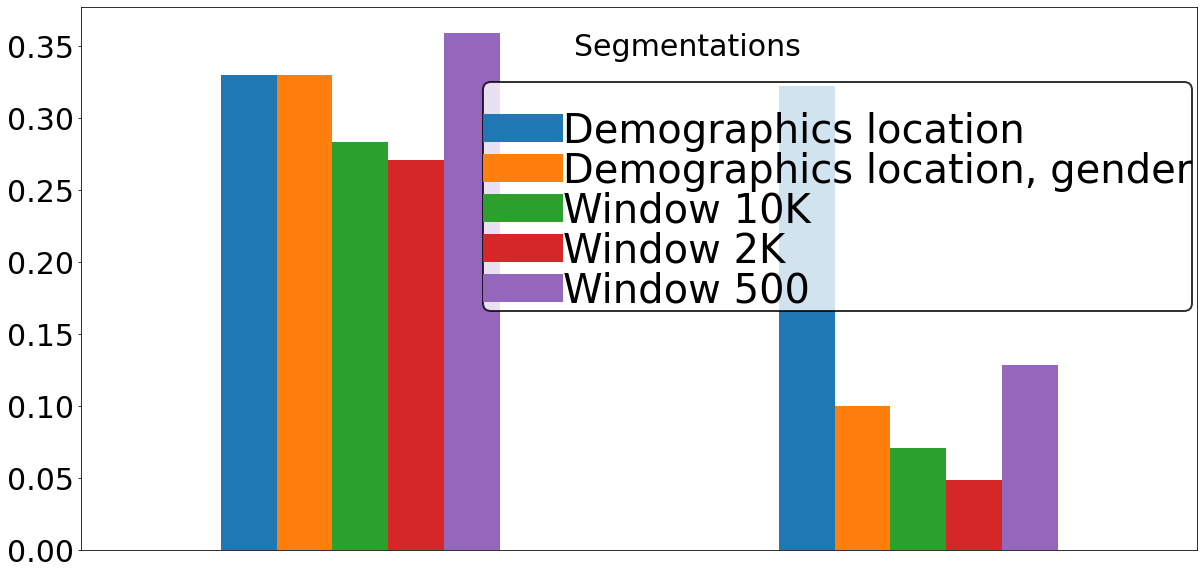

In [9]:
alpha = 0.05
approach = 1
groupby_columns = ["alpha","pivot","segmentation"]
plot_index = "coverage (size)"

pivot = [
    "Retail_Promotion ['2018-12-17', '2019-02-28']",
    "Retail_Demographics ['gender']",
]
segmentations = [
    "Demographics location, gender",
    "Demographics location",
    "Demographics gender"
    "Window 1K",
    "Window 10K",
    "Window 500",
    "Window 2K",
]
plot_hist(pivot,segmentations,groupby_columns,plot_index,approach,alpha,(.36,0.44),remove_legend=False)
plt.show()

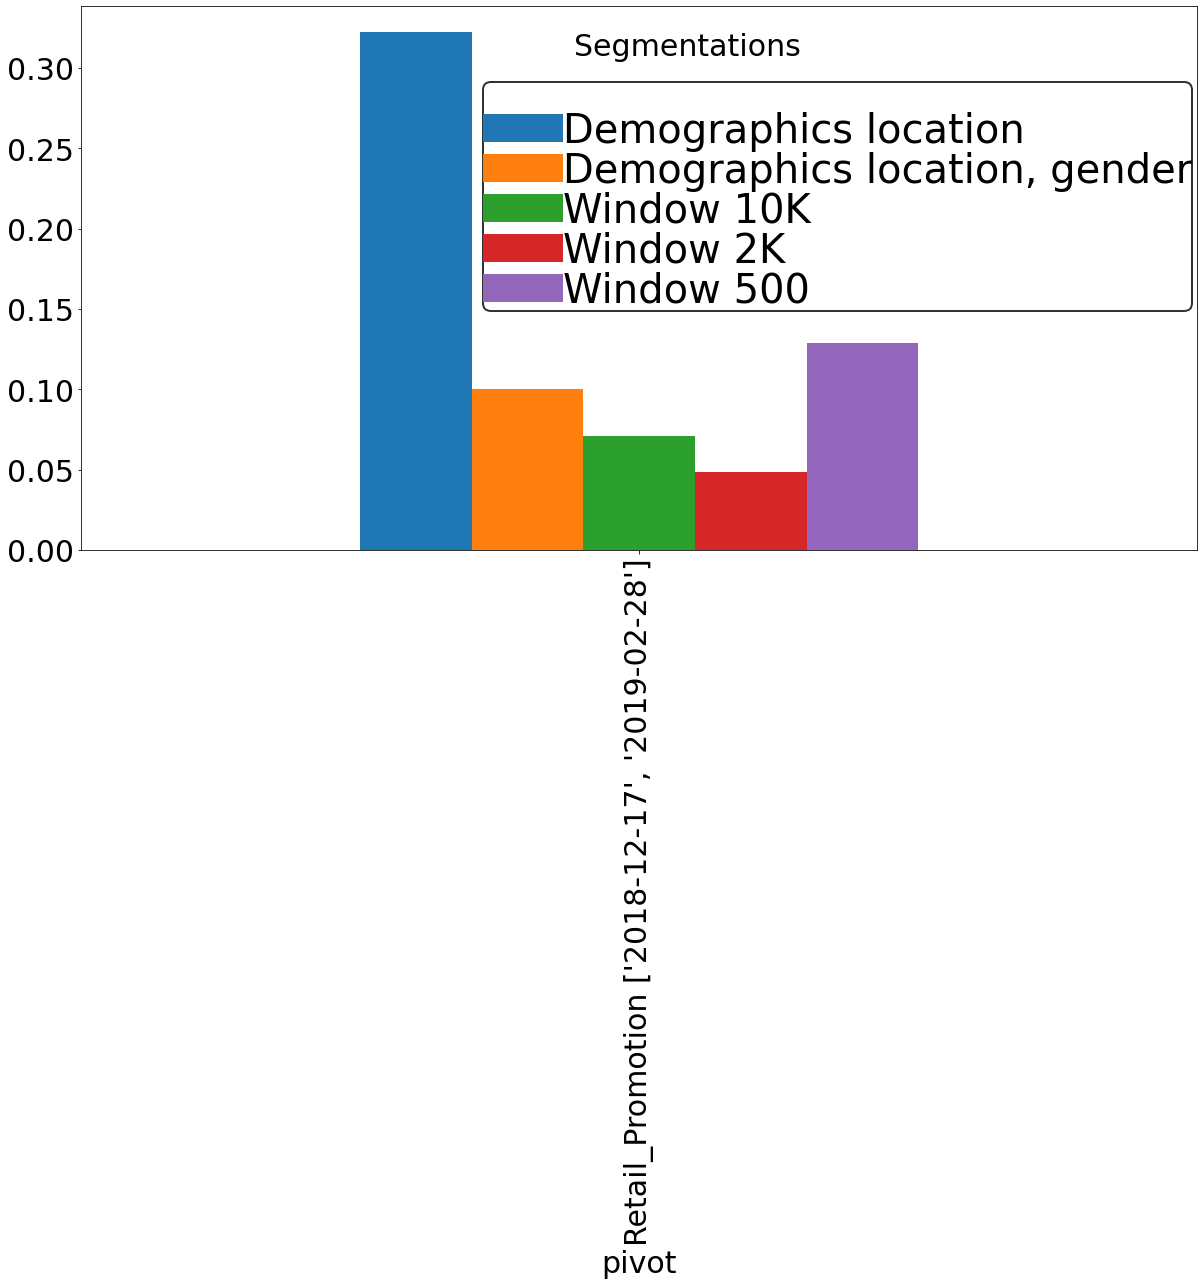

In [12]:
index = (plot_data.segmentation.isin(segmentations)) &( plot_data["pivot"].isin(pivot) )
data = plot_data[index]
groupby_columns = ["alpha","pivot","segmentation"]
plot_index = "coverage (size)"
data = data.groupby(groupby_columns)[plot_index].max().reset_index()
data = data.pivot(index="pivot",columns="segmentation",values=plot_index)
ax = data.plot(kind='bar',figsize=(20,10))
def fix_legend(ax,title="Segmentations",position=3):
    ax.legend(loc=position,title=title,borderpad=0, labelspacing=0,markerscale=4,handletextpad=0,prop={'size': 40})
    # Legend edit 
    legend = ax.get_legend()    
    legend.get_title().set_position((-150, 50)) # -10 is a guess
    legend.get_frame().set_linewidth(2)
    legend.get_frame().set_edgecolor("black")

fix_legend(ax,position=(.36,0.44))
plt.show()

# Plot figure 7

In [36]:

def extract_name(x):
    pivot = x["pivot"].replace("Retail_","").replace("Amazon_","").split()[0]
    segmentation = x["segmentation"].replace("Retail_","").replace("Amazon_","").split()[0]
    try:
        return find_query_name(pivot,segmentation)
    except:
        return None


In [144]:
files = !ls experiments/results/*.csv
files = [i for i in files if "ztest_" not in i ]
approach = 2
alpha = 0.05
plot_data = get_plot_data(files,approach=approach,alpha=alpha)
plot_data["query"] = plot_data.apply(lambda x :extract_name(x),axis=1)

index 0 is out of bounds for axis 0 with size 0
experiments/results/Retail_pivot: Demographics ['gender'] , segmentation: Demographics ['gender'].csv
index 0 is out of bounds for axis 0 with size 0
experiments/results/Retail_pivot: Demographics ['gender'] , segmentation: None .csv
'<=' not supported between instances of 'str' and 'float'
experiments/results/Retail_pivot: None [10] , segmentation: Demographics ['location'].csv
index 0 is out of bounds for axis 0 with size 0
experiments/results/Retail_pivot: None [10] , segmentation: Window 2000.csv
index 0 is out of bounds for axis 0 with size 0
experiments/results/Tafeng_pivot: Trend ['Up', 'Down'] , segmentation: Window 28D.csv
Sales_Promotion Window
Sales_Promotion Window
Sales_Promotion Window
Sales_Promotion Window
Sales_Promotion Window
Sales_Promotion Window
Sales_Promotion Window
Sales_Promotion Window
Sales_Promotion Window
Sales_Promotion Window
Sales_Promotion Window
Sales_Promotion Window
Sales_Promotion Window
Sales_Promoti

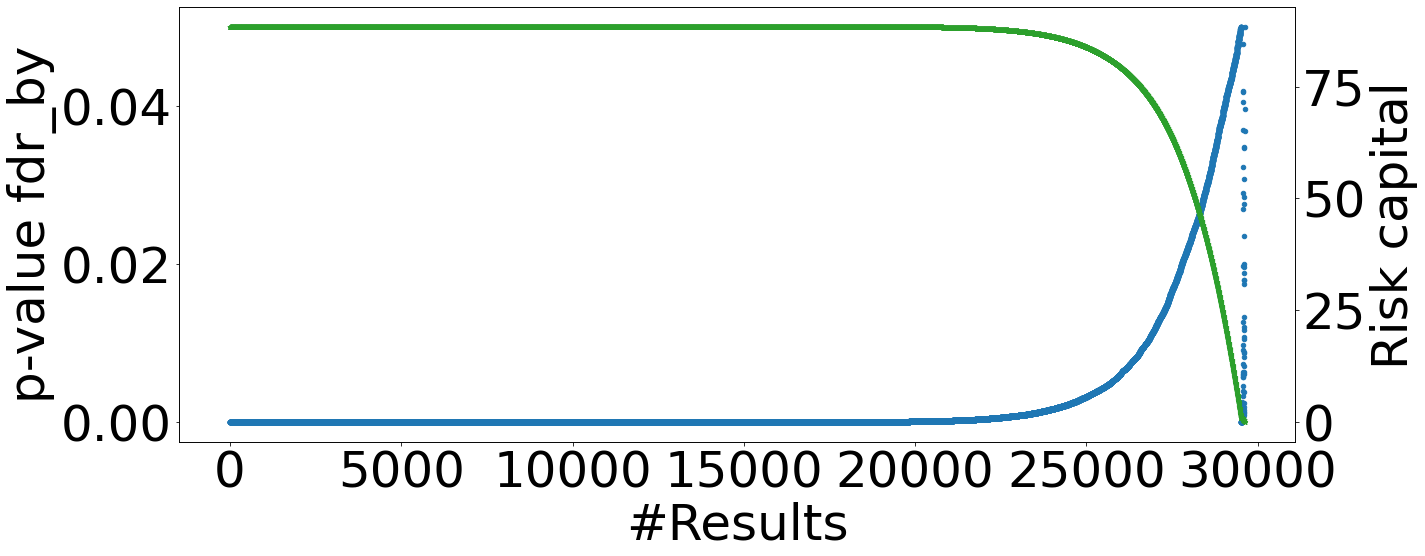

In [146]:
alpha = 0.05
approach = 1
groupby_columns = ["alpha","pivot","segmentation"]
plot_index = "coverage (size)"

pivot = [
    "Retail_Promotion ['2018-12-17', '2019-02-28']",
#     "Retail_Demographics ['gender']",
]
segmentations = [
#     "Demographics location, gender",
#     "Demographics location",
#     "Demographics gender"
#     "Window 1K",
#     "Window 10K",
#     "Window 5K",
    "Window 500",
#     "Window 2K",
]
plt.rcParams["font.size"] = "50"
import matplotlib.patches as mpatches

index = (plot_data.segmentation.isin(segmentations)) &( plot_data["pivot"].isin(pivot) )
data = plot_data[index]
for seg,i in data.groupby("segmentation"):
    ax = i.plot.scatter(x="#results",y="p-value fdr_by",marker="o",figsize=(20,8),label="p-value fdr_by")
    ax2 = ax.twinx()
    i.plot.scatter(ax=ax2,x="#results",y="budget (NN)",color="C2",marker="*")
    ax.set_xlabel("#Results")
    ax2.set_ylabel("Risk capital")
    # where some data has already been plotted to ax
    handles, labels = ax.get_legend_handles_labels()

    # manually define a new patch 
    patch = mpatches.Patch(color='C2', label="Risk Capital",fill=False)
    import matplotlib.pyplot as plt
    from matplotlib.lines import Line2D

    colors = ['blue','green', ]
    lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='--') for c in colors]
    
    labels = ['p-value fdr_by', 'Risk Capital']
    
    # handles is a list, so append manual patch
    handles.append(patch) 
    ax.get_legend().remove()
    # plot the legend
#     ax.legend(lines, labels)

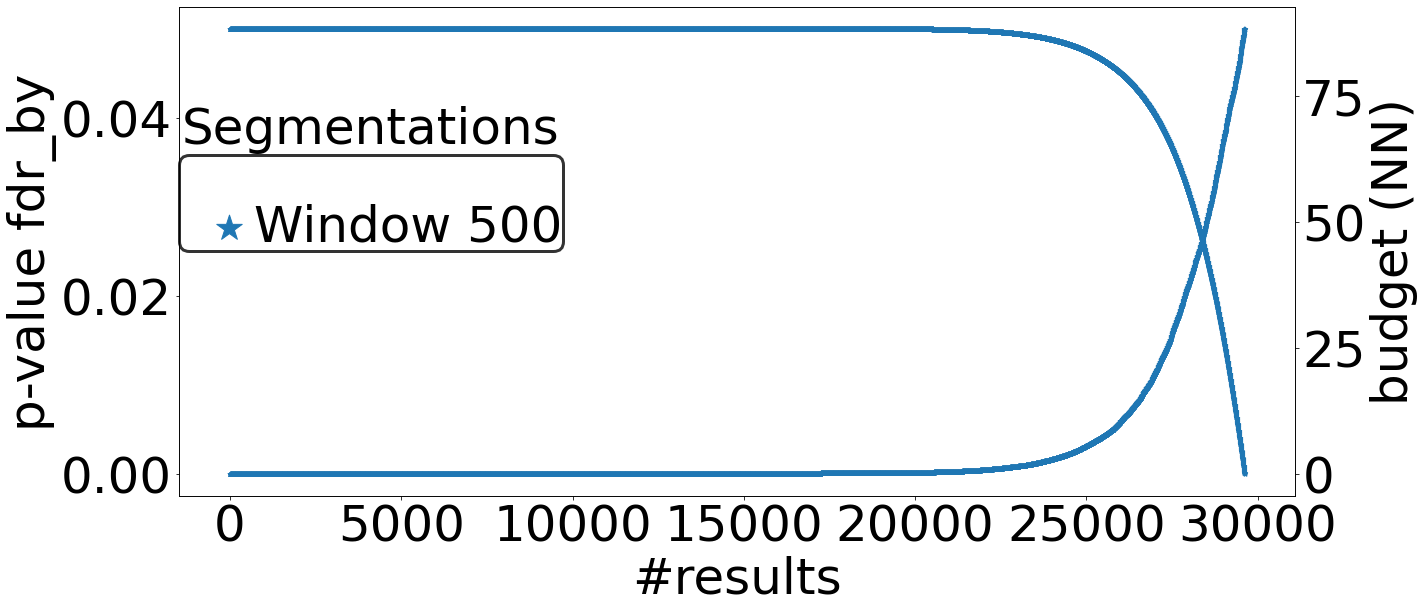

In [134]:
data = plot_data[index]
fig,ax = plt.subplots(1,1,figsize=(20,9))
ax2= ax.twinx()
for seg,i in data.groupby("pivot"):
    pass
for idx,(seg,ii) in enumerate(i.groupby("segmentation")):
    ii.plot.scatter(x="#results",y="p-value fdr_by",marker="*",label=seg,ax=ax,color=f"C{idx}")
    ii.plot.scatter(x="#results",y="budget (NN)",marker="*",label=seg,ax=ax2,color=f"C{idx}")

ax2.get_legend().remove()

fix_legend(ax,position=(0,0.5))


##  Budget for different alpha 

In [17]:
plot_data1 = get_plot_data(files,approach=approach,alpha=0.01)
plot_data2 = get_plot_data(files,approach=approach,alpha=0.05)


index 0 is out of bounds for axis 0 with size 0
experiments/results/Retail_pivot: Demographics ['gender'] , segmentation: Demographics ['gender'].csv
index 0 is out of bounds for axis 0 with size 0
experiments/results/Retail_pivot: Demographics ['gender'] , segmentation: None .csv
'<=' not supported between instances of 'str' and 'float'
experiments/results/Retail_pivot: None [10] , segmentation: Demographics ['location'].csv
index 0 is out of bounds for axis 0 with size 0
experiments/results/Retail_pivot: None [10] , segmentation: Window 2000.csv
index 0 is out of bounds for axis 0 with size 0
experiments/results/Retail_pivot: Demographics ['gender'] , segmentation: Demographics ['gender'].csv
index 0 is out of bounds for axis 0 with size 0
experiments/results/Retail_pivot: Demographics ['gender'] , segmentation: None .csv
'<=' not supported between instances of 'str' and 'float'
experiments/results/Retail_pivot: None [10] , segmentation: Demographics ['location'].csv
index 0 is out o

<AxesSubplot:xlabel='alpha'>

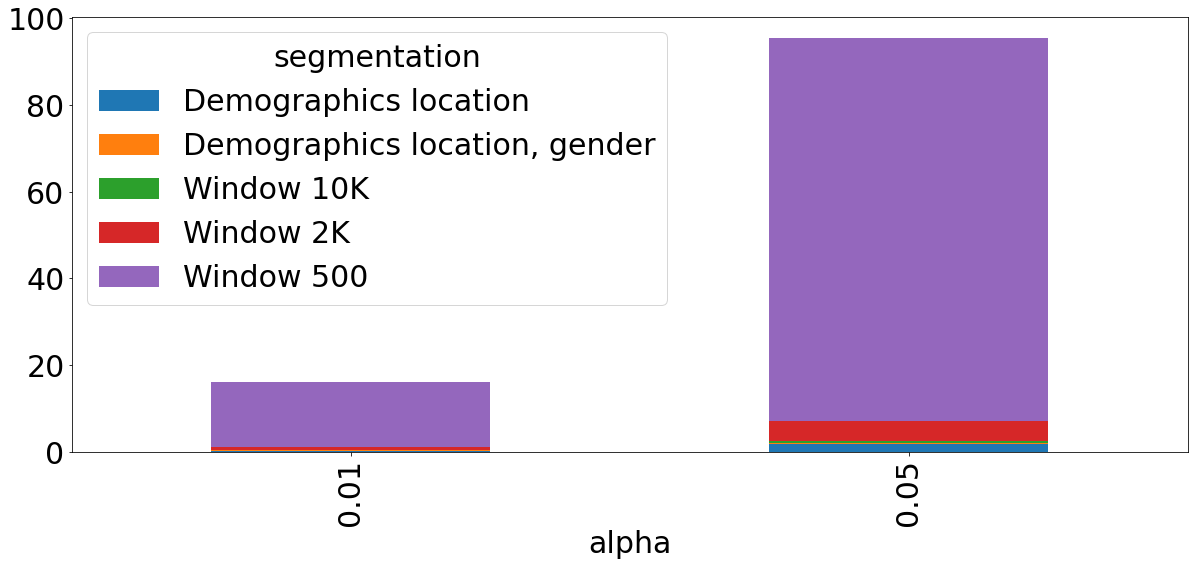

In [38]:
plot_data = pd.concat([plot_data1,plot_data2])
index = (plot_data.segmentation.isin(segmentations)) &( plot_data["pivot"].isin(pivot) )
data = plot_data[index]
groupby_columns = ["alpha","segmentation","pivot"]
data = data.groupby(groupby_columns)["budget (NN)"].max().reset_index()

data.set_index(['alpha']).pivot(columns=["segmentation"],values="budget (NN)").plot.bar(stacked=True,figsize=(20,8))

In [ ]:

plot_data = get_plot_data(files,approach=approach,alpha=alpha)
index = (plot_data.segmentation.isin(segmentations)) &( plot_data["pivot"].isin(pivot) )
data = plot_data[index]
data = data.groupby(groupby_columns)[plot_index].max().reset_index()
data = data.pivot(index="pivot",columns="segmentation",values=plot_index)
ax = data.plot(kind='bar',figsize=(20,10))
def fix_legend(ax,title="Segmentations",position=3):
    ax.legend(loc=position,title=title,borderpad=0, labelspacing=0,markerscale=4,handletextpad=0,prop={'size': 40})

    # Legend edit 
    legend = ax.get_legend()    
    legend.get_title().set_position((-150, 50)) # -10 is a guess
    legend.get_frame().set_linewidth(2)
    legend.get_frame().set_edgecolor("black")



### Plots 

1 1.3809851223778935
1 1.3809851223778935 917 917
1 6.606193377688528
1 6.606193377688528 3819 3819
1 0.32272495869322354
1 0.32272495869322354 772 772
1 10.05382004726785
1 10.05382004726785 18265 18265
1 1.1882120195035357
1 1.1882120195035357 3049 3049
1 0.10006385658177538
1 0.10006385658177538 47 47
1 2.3995341281028133
1 2.3995341281028133 912 912
1 0.5249004485325084
1 0.5249004485325084 170 170
1 0.2440555649476323
1 0.2440555649476323 60 60
1 1.0135406907867289e-51
1 1.0135406907867289e-51 1 0
index 0 is out of bounds for axis 0 with size 0
experiments/results/Retail_pivot: Demographics ['gender'] , segmentation: Demographics ['gender'].csv
1 1.3056014817385617
1 1.3056014817385617 1094 1094
1 1.3056014817385617
1 1.3056014817385617 1094 1094
1 9.495503028722716e-52
1 9.495503028722716e-52 1 0
index 0 is out of bounds for axis 0 with size 0
experiments/results/Retail_pivot: Demographics ['gender'] , segmentation: None .csv
1 0.11544042314422867
1 0.11544042314422867 50 50
1 11

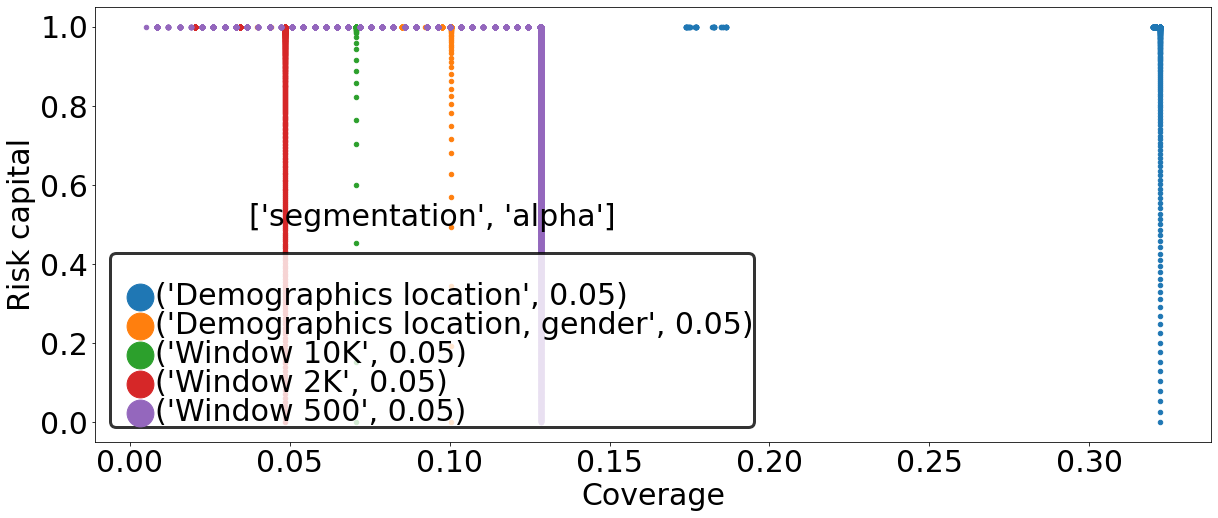

In [40]:
files = !ls experiments/results/*.csv
alpha = 0.05
plots = get_plot_data(files,approach=1,alpha=alpha)

pivot = ["Retail_Promotion ['2018-12-17', '2019-02-28']"]

segmentations = [
    "Demographics location, gender",
    "Demographics location",
    "Demographics gender"
    "Window 1K",
    "Window 10K",
    "Window 500",
    "Window 2K",
]

plot_result(plots,segmentations,pivot,plot_columns=["segmentation","alpha"],index_col="coverage (size)",remove_duplicates=False)

In [3]:
plots.groupby(["segmentation","alpha","factor"])["#results"].size().to_frame()

#results
segmentation                  alpha factor          
Demographics age              0.01  1.0000       116
                              0.05  0.0005       136
                                    0.3000       136
                                    1.0000       136
Demographics gender           0.01  1.0000         3
                              0.05  0.0005         3
                                    0.3000         3
                                    1.0000         3
Demographics location         0.01  1.0000      2180
                              0.05  0.0005      2280
                                    0.3000      2280
                                    1.0000      2280
Demographics location, gender 0.01  1.0000      1253
                              0.05  0.0005      1297
                                    0.3000      1297
                                    1.0000      1297
Window 10K                    0.01  1.0000      1892
                              0.05  0.0005      1978
                                    0.3000      1978
                                    1.0000      1978
Window 1K                     0.01  1.0000     11785
                              0.05  0.0005     12751
                                    0.3000     12751
                                    1.0000     12751
Window 200                    0.01  1.0000        98
                              0.05  0.0005       124
                                    0.3000       124
                                    1.0000       124
Window 2K                     0.01  1.0000     22875
                              0.05  0.0005     23594
                                    0.3000     23594
                                    1.0000     23594
Window 30D                    0.01  1.0000         2
                              0.05  0.0005         2
                                    0.3000         2
                                    1.0000         2
Window 3M                     0.01  1.0000         2
                              0.05  0.0005         2
                                    0.3000         2
                                    1.0000         2
Window 40D                    0.01  1.0000         5
                              0.05  0.0005         7
                                    0.3000         7
                                    1.0000         7
Window 4W                     0.01  1.0000         6
                              0.05  0.0005        12
                                    0.3000        12
                                    1.0000        12
Window 500                    0.01  1.0000     39988
                              0.05  0.0005     44537
                                    0.3000     44537
                                    1.0000     44537
Window 5K                     0.01  1.0000      7403
                              0.05  0.0005      7738
                                    0.3000      7738
                                    1.0000      7738
Window M                      0.01  1.0000         2
                              0.05  0.0005         4
                                    0.3000         4
                                    1.0000         4

In [2]:
files = !ls experiments/results/*.csv
plots = pd.DataFrame()

alpha = 0.05
factor= 1
plots1 = get_plot_data(files,approach=1,alpha=alpha,factor=factor)
plots = pd.concat([plots,plots1])

alpha = 0.05
factor= 0.0005
plots1 = get_plot_data(files,approach=1,alpha=alpha,factor=factor)
plots = pd.concat([plots,plots1])


alpha = 0.05
factor= 0.3

plots1 = get_plot_data(files,approach=1,alpha=alpha,factor=factor)
plots = pd.concat([plots,plots1])


alpha = 0.01
plots2 = get_plot_data(files,approach=1,alpha=alpha)
plots = pd.concat([plots,plots2])

pivot = ["Retail_Promotion ['2018-12-17', '2019-02-28']"]

segmentations = [
#     "Demographics location, gender",
#     "Demographics location",
#     "Demographics gender"
#     "Window 1K",
#     "Window 10K",
    "Window 500",
#     "Window 2K",
]

plot_result(plots,segmentations,pivot,plot_columns=["segmentation","alpha","factor"],index_col="coverage (#results)",remove_duplicates=False)

1 1.3809851223778935
1 1.3809851223778935 917 917
1 6.606193377688528
1 6.606193377688528 3819 3819
1 0.32272495869322354
1 0.32272495869322354 772 772
1 10.05382004726785
1 10.05382004726785 18265 18265
1 1.1882120195035357
1 1.1882120195035357 3049 3049
1 0.10006385658177538
1 0.10006385658177538 47 47
1 2.3995341281028133
1 2.3995341281028133 912 912
1 0.5249004485325084
1 0.5249004485325084 170 170
1 0.2440555649476323
1 0.2440555649476323 60 60
1 1.0135406907867289e-51
1 1.0135406907867289e-51 1 0
index 0 is out of bounds for axis 0 with size 0
experiments/results/Retail_pivot: Demographics ['gender'] , segmentation: Demographics ['gender'].csv
1 1.3056014817385617
1 1.3056014817385617 1094 1094
1 1.3056014817385617
1 1.3056014817385617 1094 1094
1 9.495503028722716e-52
1 9.495503028722716e-52 1 0
index 0 is out of bounds for axis 0 with size 0
experiments/results/Retail_pivot: Demographics ['gender'] , segmentation: None .csv
1 0.11544042314422867
1 0.11544042314422867 50 50
1 11

0.3 0.030019156974532613
0.3 0.030019156974532613 47 47
0.3 0.719860238430844
0.3 0.719860238430844 912 912
0.3 0.1574701345597525
0.3 0.1574701345597525 170 170
0.3 0.1696029778754963
0.3 0.1696029778754963 36 36
0.3 0.00012793960900150668
0.3 0.00012793960900150668 100 100
0.3 6.423473716850262e-08
0.3 6.423473716850262e-08 5 5
0.3 0.006938840588479545
0.3 0.006938840588479545 1 0
index 0 is out of bounds for axis 0 with size 0
experiments/results/Tafeng_pivot: Trend ['Up', 'Down'] , segmentation: Window 28D.csv
0.3 0.0007286808197996636
0.3 0.0007286808197996636 2 2
0.3 0.00033214829714184254
0.3 0.00033214829714184254 2 2
0.3 0.02303799924762312
0.3 0.02303799924762312 7 7
0.3 0.06202617868809886
0.3 0.06202617868809886 12 12
0.3 0.012396711592270862
0.3 0.012396711592270862 4 4
1 0.2731298371009129
1 0.2731298371009129 866 866
1 1.136706226020725
1 1.136706226020725 3605 3605
1 0.08275539278375259
1 0.08275539278375259 762 762
1 1.4945527092389566
1 1.4945527092389566 17949 17949


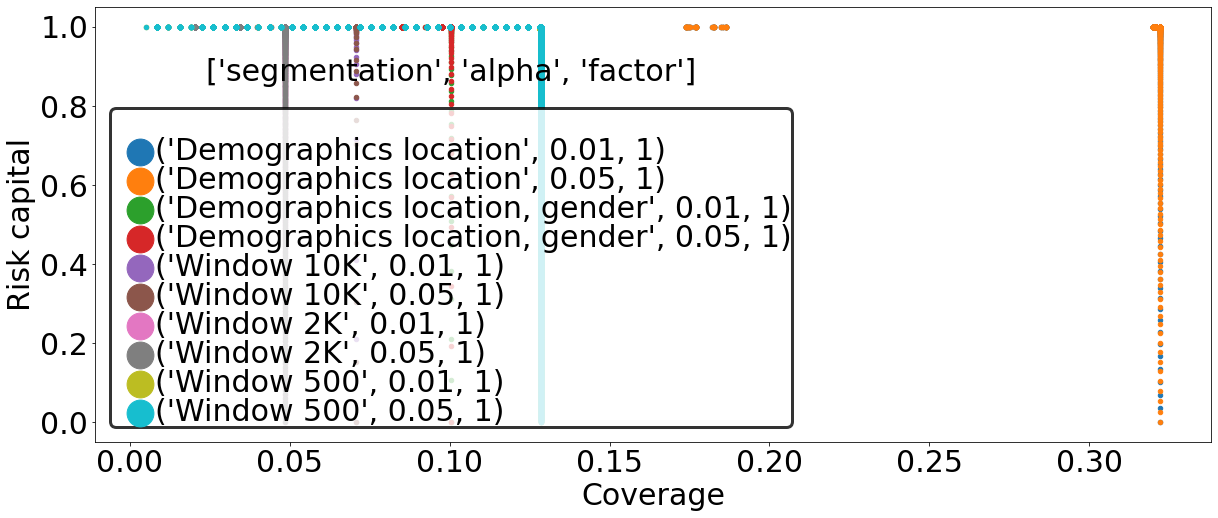

In [9]:
plot_result(plots,segmentations,pivot,plot_columns=["segmentation","alpha","factor"],index_col="coverage (size)",remove_duplicates=False)

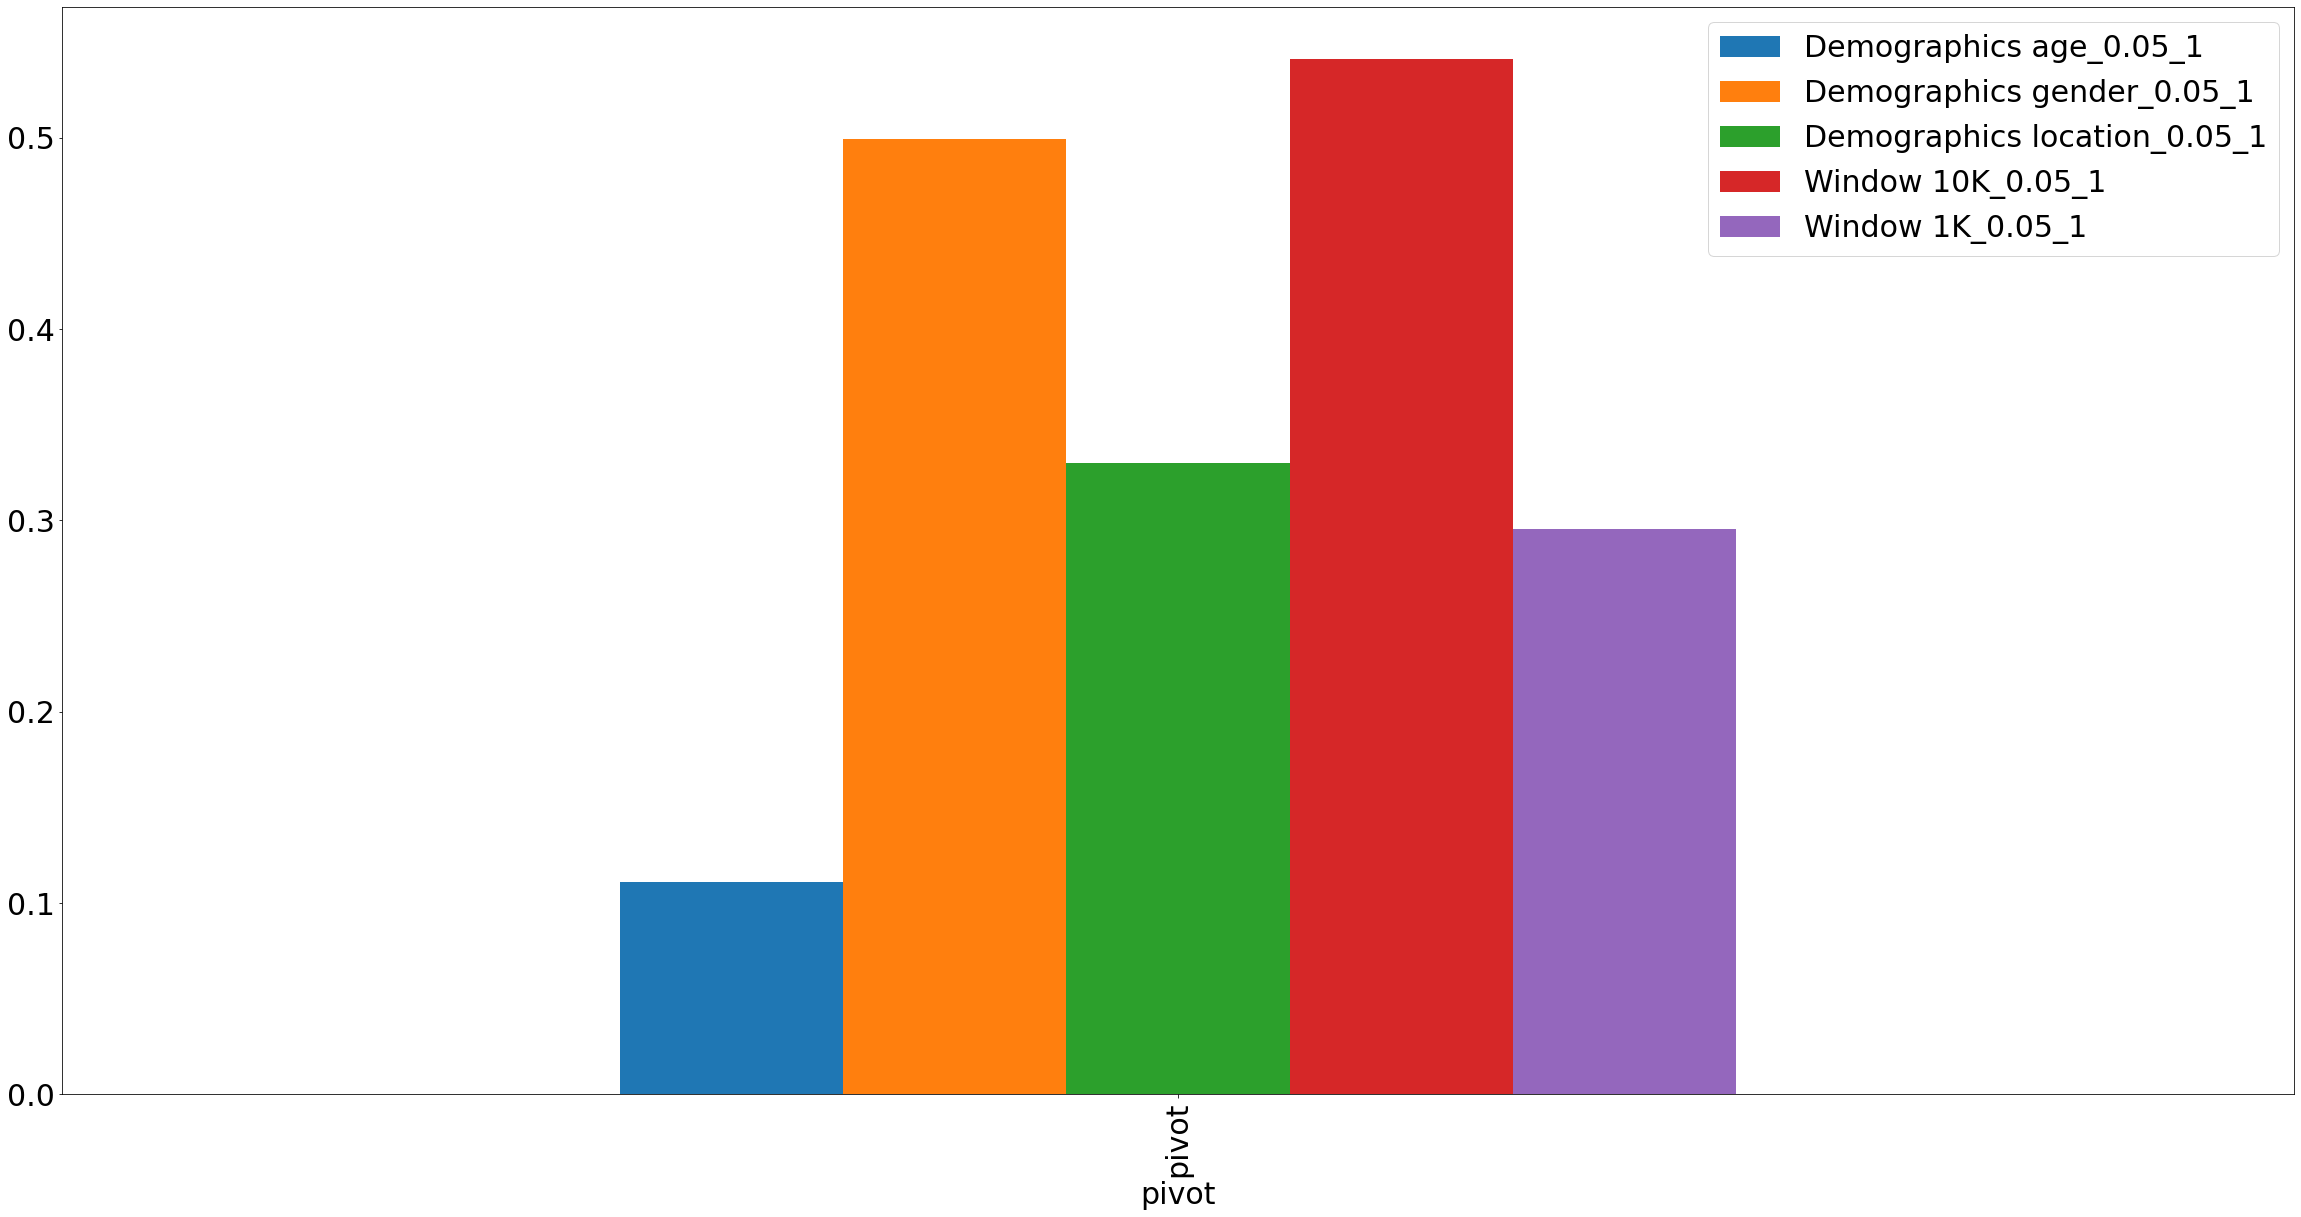

In [66]:
# plots = plots[plots.segmentation.isin(segmentations)]
pivot = ["Retail_Promotion ['2018-12-17', '2019-02-28']"]

segmentations = [
    "Demographics location, gender",
    "Demographics location",
    "Demographics gender"
    "Window 1K",
    "Window 10K",
    "Window 500",
    "Window 2K",
]
i = plots[plots["pivot"].isin(pivot)]
i = plots[plots.segmentation.isin(segmentations)]
a = plots.groupby(["segmentation","alpha","factor"])['coverage (size)'].max().reset_index()
a["pivot"] = "pivot"
a = a.pivot(index="pivot",columns = ["segmentation","alpha","factor"],values= "coverage (size)")
a.columns = ["_".join(str(ii) for ii in i) for i in a.columns]
a = a[[i for i in sorted(a.columns) if "location, ge" not in i][:5]]
ax = a.plot.bar(figsize=(40,20))


0.3 0.41429553671336805
0.3 0.41429553671336805 917 917
0.3 1.9818580133065582
0.3 1.9818580133065582 3819 3819
0.3 0.09681748760796706
0.3 0.09681748760796706 772 772
0.3 3.016146014180355
0.3 3.016146014180355 18265 18265
0.3 0.3564636058510607
0.3 0.3564636058510607 3049 3049
0.3 0.030019156974532613
0.3 0.030019156974532613 47 47
0.3 0.719860238430844
0.3 0.719860238430844 912 912
0.3 0.1574701345597525
0.3 0.1574701345597525 170 170
0.3 0.07321666948428969
0.3 0.07321666948428969 60 60
0.3 3.0406220723601864e-52
0.3 3.0406220723601864e-52 1 0
index 0 is out of bounds for axis 0 with size 0
experiments/results/Retail_pivot: Demographics ['gender'] , segmentation: Demographics ['gender'].csv
0.3 0.3916804445215685
0.3 0.3916804445215685 1094 1094
0.3 0.3916804445215685
0.3 0.3916804445215685 1094 1094
0.3 2.848650908616815e-52
0.3 2.848650908616815e-52 1 0
index 0 is out of bounds for axis 0 with size 0
experiments/results/Retail_pivot: Demographics ['gender'] , segmentation: None .

TypeError: scatter() missing 2 required positional arguments: 'x' and 'y'

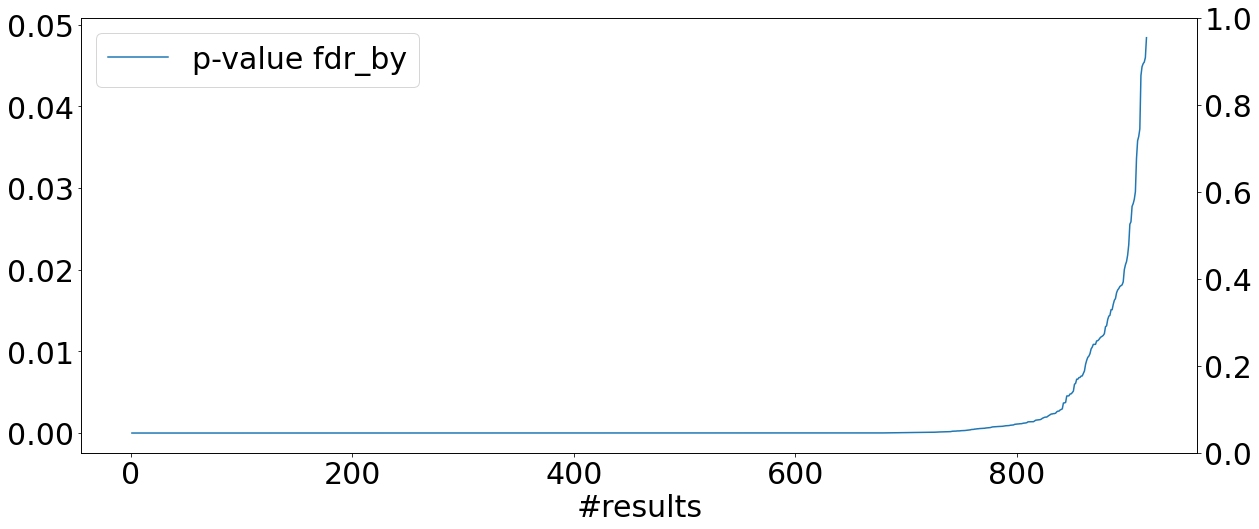

In [87]:
# plots = get_plot_data(files,approach=1,alpha=alpha,factor=factor)
for _,i in  plots.groupby(["pivot","segmentation","alpha","factor"]):
    break
ax = i.set_index("#results").sort_index()[["p-value fdr_by"]].plot(figsize=(20,8))
ax2 = ax.twinx()
ax = i.set_index("#results").sort_index()[["budget"]].plot.scatter(x="index",y,ax=ax2,figsize=(20,8),color="C2")


,pivot,segmentation,p-value fdr_by,budget,coverage (#results),#results,coverage (size),budget (NN),alpha,factor
96,"Amazon_Promotion ['2015-11-20', '2016-01-01']",Window 10K,1.433156e-159,1.000000,0.001091,1.0,0.028296,1.380985,0.05,1
97,"Amazon_Promotion ['2015-11-20', '2016-01-01']",Window 10K,2.679760e-156,1.000000,0.002181,2.0,0.028296,1.380985,0.05,1
95,"Amazon_Promotion ['2015-11-20', '2016-01-01']",Window 10K,6.313379e-152,1.000000,0.003272,3.0,0.028296,1.380985,0.05,1
114,"Amazon_Promotion ['2015-11-20', '2016-01-01']",Window 10K,7.485940e-148,1.000000,0.004362,4.0,0.028296,1.380985,0.05,1
94,"Amazon_Promotion ['2015-11-20', '2016-01-01']",Window 10K,6.922520e-143,1.000000,0.005453,5.0,0.028296,1.380985,0.05,1
...,...,...,...,...,...,...,...,...,...,...
1284,"Amazon_Promotion ['2015-11-20', '2016-01-01']",Window 10K,5.722186e-04,0.068236,0.995638,913.0,0.091911,0.094233,0.05,1
1271,"Amazon_Promotion ['2015-11-20', '2016-01-01']",Window 10K,1.801774e-03,0.066931,0.996728,914.0,0.091911,0.092431,0.05,1
1297,"Amazon_Promotion ['2015-11-20', '2016-01-01']",Window 10K,1.814595e-02,0.053792,0.997819,915.0,0.091911,0.074285,0.05,1
1287,"Amazon_Promotion ['2015-11-20', '2016-01-01']",Window 10K,4.841503e-02,0.018733,0.998909,916.0,0.091911,0.025870,0.05,1


1 1.3809851223778935
1 6.606193377688528
1 0.32272495869322354
1 10.05382004726785
1 1.1882120195035357
1 0.10006385658177538
1 2.3995341281028133
1 0.5249004485325084
1 0.2440555649476323
1 1.0135406907867289e-51
index 0 is out of bounds for axis 0 with size 0
experiments/results/Retail_pivot: Demographics ['gender'] , segmentation: Demographics ['gender'].csv
1 1.3056014817385617
1 1.3056014817385617
1 9.495503028722716e-52
index 0 is out of bounds for axis 0 with size 0
experiments/results/Retail_pivot: Demographics ['gender'] , segmentation: None .csv
1 0.11544042314422867
1 11.24804297704075
1 2.8482369472866194
1 0.7882551489289167
1 0.5964118794586306
1 52.843855311275874
1 2.9348735273927607e-18
'<=' not supported between instances of 'str' and 'float'
experiments/results/Retail_pivot: None [10] , segmentation: Demographics ['location'].csv
1 0.0
index 0 is out of bounds for axis 0 with size 0
experiments/results/Retail_pivot: None [10] , segmentation: Window 2000.csv
1 6.28352

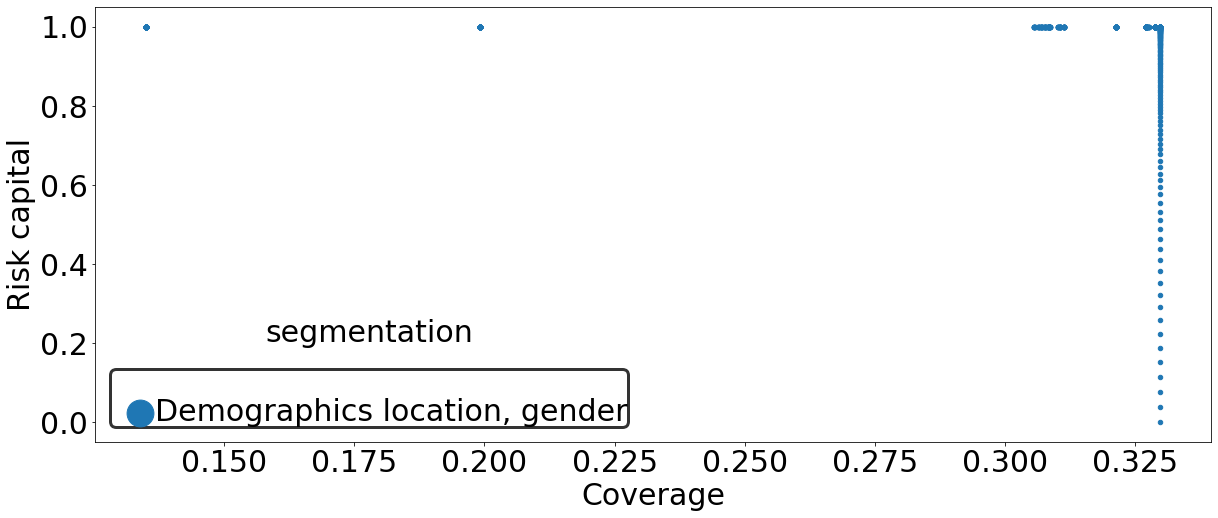

In [8]:
files = !ls experiments/results/*.csv
alpha = 0.05
plots = get_plot_data(files,approach=1,alpha=alpha,optimize=False)
pivot = [
#     "Amazon_Promotion ['2015-11-20', '2016-01-01']",
#     "Retail_Promotion ['2018-12-17', '2019-02-28']",
    "Retail_Demographics ['gender']",
]

segmentations = [
    "Demographics location, gender",
    "Demographics gender"
#     "Window 1K",
#     "Window 10K",
#     "Window 500",
#     "Window 2K",
]

plot_result(plots,segmentations,pivot,index_col="coverage (size)",remove_duplicates=False)


In [3]:
plots = get_plot_data(files,approach=1,alpha=alpha,optimize=False)
i = plots[plots["pivot"].isin(pivot)]
i = i.reset_index(drop=True)
i = i[i.segmentation.isin(segmentations)]
i.loc[i["coverage (size)"].nlargest(10).index]

1.3056014817385617
1.3056014817385608
1.3056014817385617
1.3056014817385608
'<=' not supported between instances of 'str' and 'float'
experiments/results/Retail_pivot: None [10] , segmentation: Demographics ['location'].csv
1.8805358083851478
1.8805358083851476
0.24561265649680902
0.2456126564968091


,p-value fdr_by,budget,coverage (#results),#results,coverage (size),pivot,segmentation,alpha
1565,1.903862e-58,1.0,0.431444,472,0.329829,Retail_Demographics ['gender'],"Demographics location, gender",0.05
1566,1.909676e-58,1.0,0.432358,473,0.329829,Retail_Demographics ['gender'],"Demographics location, gender",0.05
1567,2.390945e-58,1.0,0.433272,474,0.329829,Retail_Demographics ['gender'],"Demographics location, gender",0.05
1568,1.131480e-57,1.0,0.434186,475,0.329829,Retail_Demographics ['gender'],"Demographics location, gender",0.05
1569,1.424515e-57,1.0,0.435101,476,0.329829,Retail_Demographics ['gender'],"Demographics location, gender",0.05
1570,4.095573e-57,1.0,0.436015,477,0.329829,Retail_Demographics ['gender'],"Demographics location, gender",0.05
1571,8.049597e-57,1.0,0.436929,478,0.329829,Retail_Demographics ['gender'],"Demographics location, gender",0.05
1572,1.093922e-56,1.0,0.437843,479,0.329829,Retail_Demographics ['gender'],"Demographics location, gender",0.05
1573,1.154363e-56,1.0,0.438757,480,0.329829,Retail_Demographics ['gender'],"Demographics location, gender",0.05
1574,2.223707e-56,1.0,0.439671,481,0.329829,Retail_Demographics ['gender'],"Demographics location, gender",0.05


In [4]:
plots = get_plot_data(files,approach=2,alpha=alpha,optimize=False)
i = plots[plots["pivot"].isin(pivot)]
i = i.reset_index(drop=True)
i = i[i.segmentation.isin(segmentations)]
i.loc[i["coverage (size)"].nlargest(10).index]

1.3056014817385617
1.3056014817385608
1.3056014817385617
1.3056014817385608
'<=' not supported between instances of 'str' and 'float'
experiments/results/Retail_pivot: None [10] , segmentation: Demographics ['location'].csv
1.8805358083851478
1.8805358083851476
0.24561265649680902
0.2456126564968091


,p-value fdr_by,budget,coverage (#results),#results,coverage (size),pivot,segmentation,alpha
2167,7.218346e-41,0.006289,0.981718,1074,0.41038,Retail_Demographics ['gender'],"Demographics location, gender",0.05
2168,6.276858e-159,0.006289,0.982633,1075,0.41038,Retail_Demographics ['gender'],"Demographics location, gender",0.05
2169,1.903862e-58,0.006289,0.983547,1076,0.41038,Retail_Demographics ['gender'],"Demographics location, gender",0.05
2170,1.337032e-102,0.006289,0.984461,1077,0.41038,Retail_Demographics ['gender'],"Demographics location, gender",0.05
2171,1.409760e-33,0.006289,0.985375,1078,0.41038,Retail_Demographics ['gender'],"Demographics location, gender",0.05
2172,1.526714e-73,0.006289,0.986289,1079,0.41038,Retail_Demographics ['gender'],"Demographics location, gender",0.05
2173,5.547804e-26,0.006289,0.987203,1080,0.41038,Retail_Demographics ['gender'],"Demographics location, gender",0.05
2174,2.228949e-67,0.006289,0.988117,1081,0.41038,Retail_Demographics ['gender'],"Demographics location, gender",0.05
2175,3.004387e-24,0.006289,0.989031,1082,0.41038,Retail_Demographics ['gender'],"Demographics location, gender",0.05
2176,9.749097e-45,0.006289,0.989945,1083,0.41038,Retail_Demographics ['gender'],"Demographics location, gender",0.05


In [4]:
get_data("Tafeng")

FileNotFoundError: [Errno 2] No such file or directory: '/home/abdelouahab/PFE/lcm-tests/datasets/Total/transactions.csv'

index 0 is out of bounds for axis 0 with size 0
experiments/results/Retail_pivot: Demographics ['gender'] , segmentation: Demographics ['gender'].csv
index 0 is out of bounds for axis 0 with size 0
experiments/results/Retail_pivot: Demographics ['gender'] , segmentation: None .csv
'<=' not supported between instances of 'str' and 'float'
experiments/results/Retail_pivot: None [10] , segmentation: Demographics ['location'].csv
index 0 is out of bounds for axis 0 with size 0
experiments/results/Retail_pivot: None [10] , segmentation: Window 2000.csv


Text(0.5, 0, '#Results')

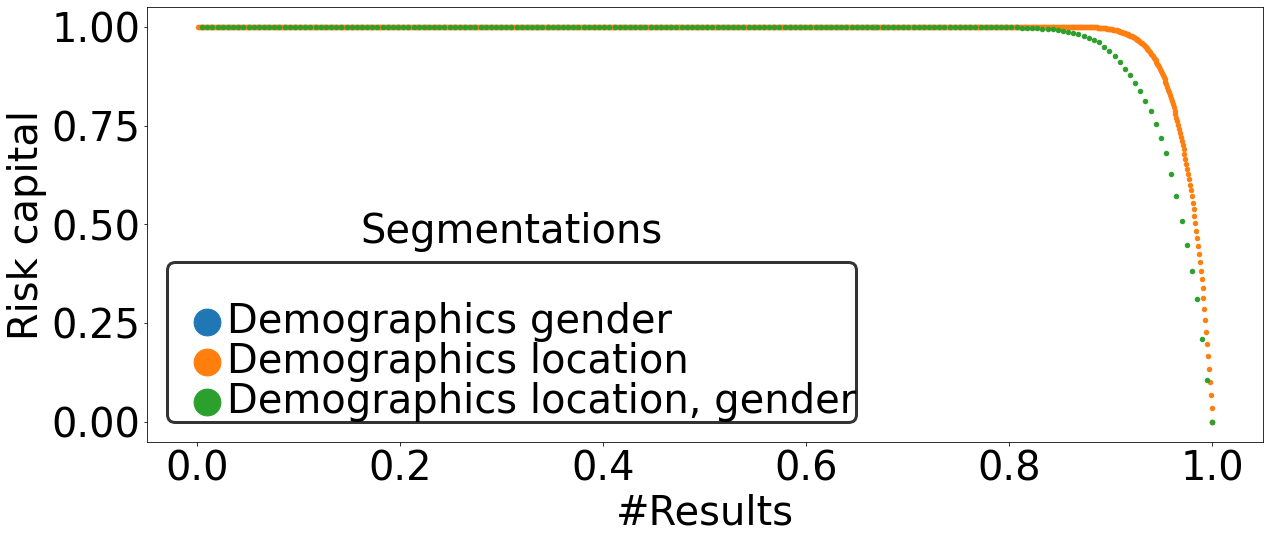

In [78]:
files = !ls experiments/results/*.csv
alpha = 0.01
plots = get_plot_data(files,approach=1,alpha=alpha)
pivot = ["Retail_Promotion ['2018-12-17', '2019-02-28']"]

segmentations = [
    "Demographics location, gender",
    "Demographics location",
    "Demographics gender"
#     "Window 1K",
#     "Window 10K",
#     "Window 500",
#     "Window 2K",
]

i = plots[plots["pivot"].isin(pivot)].sort_index()
plt.rcParams["font.size"] = "40"

i = i[i.segmentation.isin(segmentations)]


i["coverage"] = i.index
i = i.pivot(index="coverage",columns="segmentation",values="budget")



fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(20,8))
for idx,col in enumerate(i.columns):
    i.reset_index().plot.scatter(x="coverage",y=col,ax=ax,label=col,color=f'C{idx}')

fix_legend(ax)

plt.ylabel("Risk capital")
plt.xlabel("#Results")

In [65]:
segmentations = [
    "Demographics location, gender",
    "Demographics location",
    "Demographics gender"
#     "Window 1K",
#     "Window 500",
#     "Window 2K",
]

i = plots[plots["pivot"].isin(pivot)].sort_index()
i = i[i.segmentation.isin(segmentations)]

i["alpha"] = alpha
i = i.rename(columns = {"budget":"Risk Capital"})
res = pd.DataFrame()
for _,df in i.groupby("segmentation"):
    size = df.shape[0]//10
    if df.shape[0]>10:
        df = df.iloc[::size]
    res = pd.concat([res,df])
res["coverage (#results)"] = res.index
res.reset_index(drop=True).to_csv(f"Retail_Q4_{alpha}.csv")

In [77]:
files = !ls Retail_Q*0*.csv
df = pd.DataFrame()
for i in files:
    i = pd.read_csv(i,index_col=0)
    df = pd.concat([df,i])
df.to_csv("Retail_(Q3,Q4),(0.01,0.05).csv")
df

,pivot,segmentation,p-value fdr_by,Risk Capital,#results,coverage (size),alpha,coverage (#results)
0,"Retail_Promotion ['2018-12-17', '2019-02-28']",Window 1K,1.541012e-38,1.000000,1.0,0.010158,0.01,0.000127
1,"Retail_Promotion ['2018-12-17', '2019-02-28']",Window 1K,1.369104e-20,1.000000,785.0,0.038299,0.01,0.100013
2,"Retail_Promotion ['2018-12-17', '2019-02-28']",Window 1K,1.382493e-16,1.000000,1569.0,0.066440,0.01,0.199898
3,"Retail_Promotion ['2018-12-17', '2019-02-28']",Window 1K,9.026975e-14,1.000000,2353.0,0.080511,0.01,0.299783
4,"Retail_Promotion ['2018-12-17', '2019-02-28']",Window 1K,1.557227e-11,1.000000,3137.0,0.087546,0.01,0.399669
...,...,...,...,...,...,...,...,...
20,"Retail_Promotion ['2018-12-17', '2019-02-28']","Demographics location, gender",5.359035e-09,1.000000,121.0,0.100436,0.05,0.596059
21,"Retail_Promotion ['2018-12-17', '2019-02-28']","Demographics location, gender",7.613611e-07,0.999986,141.0,0.100436,0.05,0.694581
22,"Retail_Promotion ['2018-12-17', '2019-02-28']","Demographics location, gender",4.048892e-05,0.999057,161.0,0.100436,0.05,0.793103
23,"Retail_Promotion ['2018-12-17', '2019-02-28']","Demographics location, gender",1.339750e-03,0.960765,181.0,0.100436,0.05,0.891626


In [6]:

plots = get_plot_data(files,approach=2)
pivot = ["Amazon_Promotion ['2016-11-20', '2017-01-01']","Retail_Demographics ['gender']"]

print(pivot)
segmentations = [
    "Window 10K",
    "Window 500",
    "Window 2K",
]


i = plots[plots["pivot"].isin(pivot)].sort_index()
plt.rcParams["font.size"] = "40"

i = i[i.segmentation.isin(segmentations)]
i
# i = i.replace(cols)
i["coverage"] = i.index
i = i.pivot(index="coverage",columns="segmentation",values="budget").interpolate()



fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(20,8))
for idx,col in enumerate(i.columns):
    i.reset_index().plot.scatter(x="coverage",y=col,ax=ax,label=col,color=f'C{idx}')

fix_legend(ax)

plt.ylabel("Risk capital")
plt.xlabel("#Results")


NameError: name 'files' is not defined

In [12]:
a = !ls experiments/results/Tafeng_pivot:\ T*
for i in a[3:]:
    print(i)
    i = pd.read_csv(i,index_col=0)
    print(i.shape)
    break

    
a = multipletests(i.sort_values("p-value")["p-value"],method=error_arg,alpha=0.7)
a[0].sum()

experiments/results/Tafeng_pivot: Trend ['Up', 'Down'] , segmentation: Window 10D.csv
(96, 20)


0

In [13]:
files = !ls experiments/results/*.csv
files = [i for i in files if "Tafeng" in i]
plots = get_plot_data(files,approach=2)
plots[plots.segmentation=="Window 2000"]

index 0 is out of bounds for axis 0 with size 0
experiments/results/Tafeng_pivot: Promotion ['2001-01-24', '2001-01-24'] , segmentation: Demographics ['age'].csv
index 0 is out of bounds for axis 0 with size 0
experiments/results/Tafeng_pivot: Trend ['Up', 'Down'] , segmentation: Demographics ['age'].csv
index 0 is out of bounds for axis 0 with size 0
experiments/results/Tafeng_pivot: Trend ['Up', 'Down'] , segmentation: Window 28D.csv


,pivot,segmentation,p-value fdr_by,budget,#results
0.618866,"Tafeng_Trend ['Up', 'Down']",Window 2000,3.397259e-16,1.0,0.333333
0.937733,"Tafeng_Trend ['Up', 'Down']",Window 2000,5.551834e-47,0.0,1.000000


No handles with labels found to put in legend.


["Tafeng_Trend ['Up', 'Down']"]


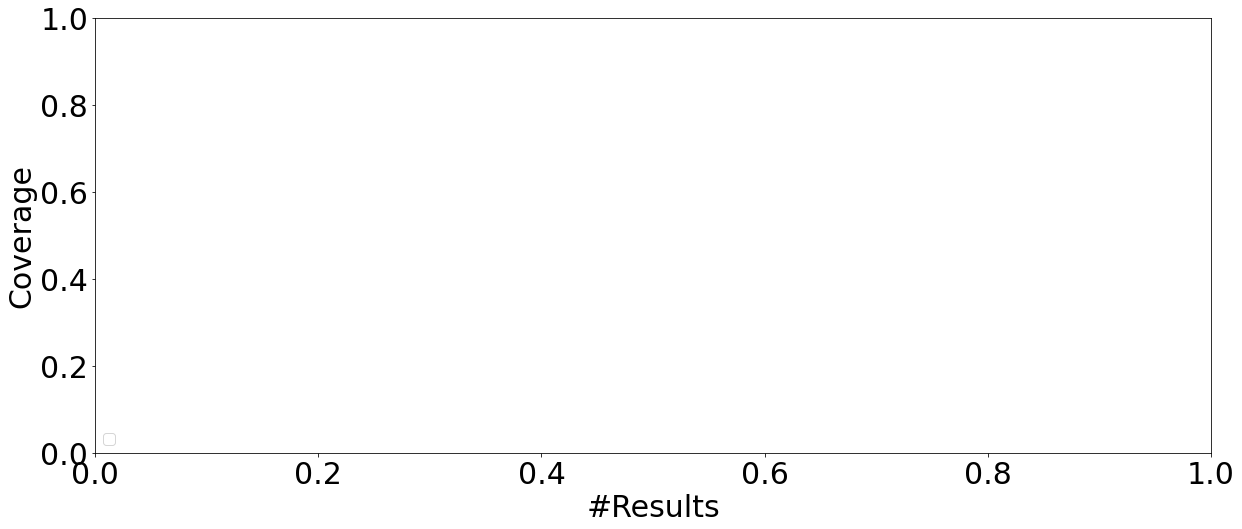

In [ ]:
cols = {
    "Demographics location" : "Demographics location Q9" ,
    'Window 10000': 'Window 10000 Q7',
    'Window 2000': 'Window 2000 Q7',
    'Window 500': 'Window 500 Q7',
    
}

In [16]:
pivot = ["Demographics ['gender']"]
i = plots[plots["pivot"].isin(pivot)]
segmentations = [
    "Demographics location", #Q9
#     "Demographics gender",
    'Window 10000',          #Q7
#     'Window 200',
    'Window 2000',
#     'Window 5000',
#     'Window 1000',
    'Window 500'
]

print(pivot)
plt.rcParams["font.size"] = "40"

i = i[i.segmentation.isin(segmentations)]
i = i.replace(cols)
i = i.reset_index().drop_duplicates("coverage",keep="first")
i = i.pivot(index="coverage",columns="segmentation",values="budget")
# ax = i.plot(figsize=(20,8),marker="o")


fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(20,8))
for idx,col in enumerate(i.columns):
    i.reset_index().plot.scatter(x="coverage",y=col,ax=ax,label=col,color=f'C{idx}')

def fix_legend(ax):
    ax.legend(loc=3,title="Segmentations",borderpad=0, labelspacing=0,markerscale=6,handletextpad=-0.5)

    # Legend edit 
    legend = ax.get_legend()    
    legend.get_title().set_position((0, 50)) # -10 is a guess
    legend.get_frame().set_linewidth(3)
    legend.get_frame().set_edgecolor("black")
fix_legend(ax)

plt.ylabel("Risk capital")
plt.xlabel("#Results")

NameError: name 'plots' is not defined

["Promotion ['2018-12-17', '2019-02-28']"]


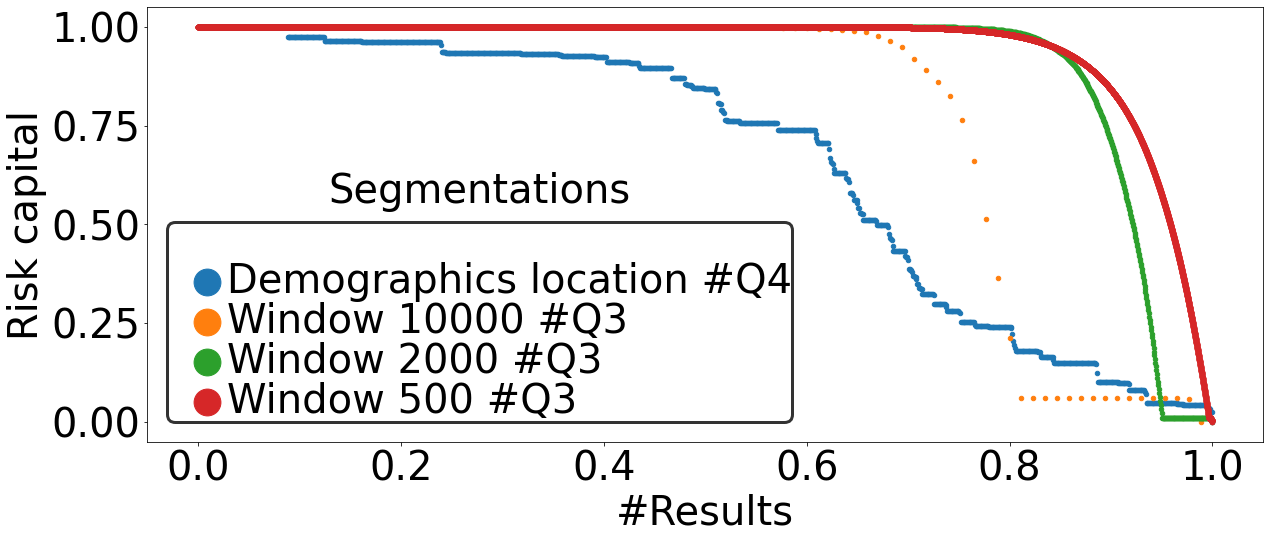

In [203]:
pivot = ["Promotion ['2018-12-17', '2019-02-28']"]
cols = {
    "Demographics location" : "Demographics location #Q4" ,
    'Window 10000': 'Window 10000 #Q3',
    'Window 2000': 'Window 2000 #Q3',
    'Window 500': 'Window 500 #Q3',
    
}
print(pivot)
i = plots[plots["pivot"].isin(pivot)]
segmentations = [
    "Demographics location", #Q4
#     "Demographics gender",
    'Window 10000',          #Q3
#     'Window 200',
#     'Window 5000',
    'Window 2000',
    'Window 500'
]
i = i[i.segmentation.isin(segmentations)]
i = i.replace(cols)
i = i.reset_index().drop_duplicates("coverage",keep="first")
i = i.pivot(index="coverage",columns="segmentation",values="budget")
# ax = i.plot(figsize=(20,8),marker="o")


fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(20,8))
for idx,col in enumerate(i.columns):
    i.reset_index().plot.scatter(x="coverage",y=col,ax=ax,label=col,color=f'C{idx}',marker="o")
    
ax.legend(loc=3, prop={'size': 35},title="segmentation",markerscale=6)
fix_legend(ax)

plt.ylabel("Risk capital")
plt.xlabel("#Results")
plt.show()

Text(0.5, 0, 'Coverage')

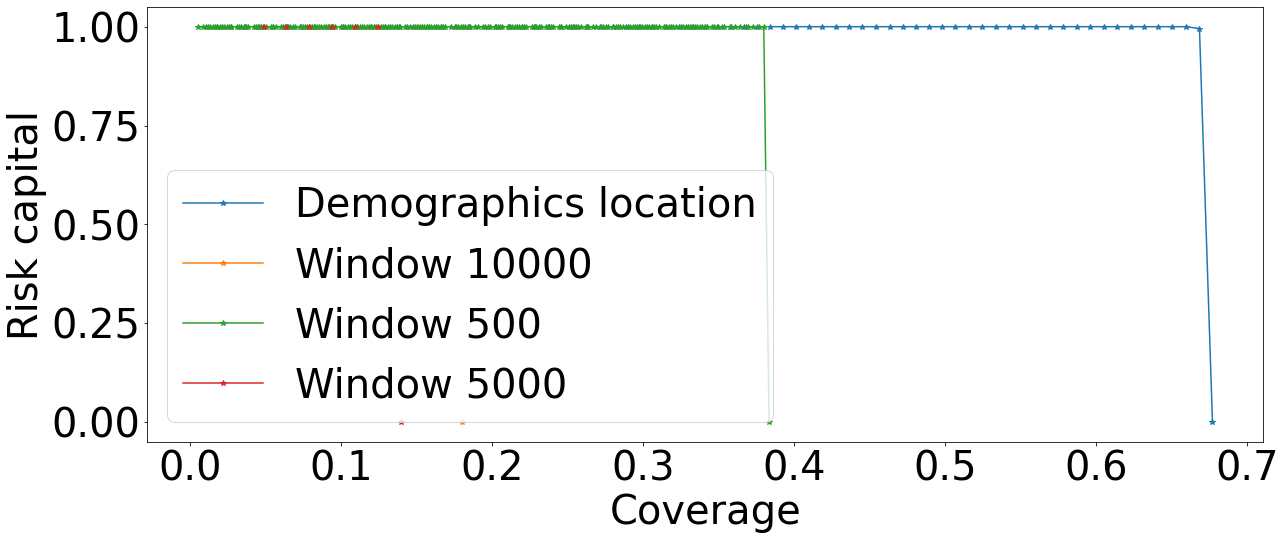

In [6]:
pivot = ["Promotion ['2018-12-17', '2019-02-28']"]

i = plots[plots["pivot"].isin(pivot)]
segmentations = [
    "Demographics location",
#     "Demographics gender",
    'Window 10000',
#     'Window 2000',
    'Window 5000',
#     'Window 1000',
    'Window 500'
]
i = i[i.segmentation.isin(segmentations)]
i = i.reset_index().drop_duplicates("coverage",keep="first")
i = i.pivot(index="coverage",columns="segmentation",values="budget")
ax = i.plot(figsize=(20,8),marker="*")
ax.legend(loc=3, prop={'size': 40})
plt.ylabel("Risk capital")
plt.xlabel("Coverage")

In [42]:
i.nunique()

segmentation
Demographics location    30
Window 10000              4
Window 500               69
Window 5000               3
dtype: int64

In [2]:

for i in files:
    result = pd.read_csv(i,index_col=0)
    result = result[result["chi-squared test"]>=0.05]

    try:
        a = multipletests(result["p-value"],method=error_arg)
        result[corrected_err_column] =  a[1]
        result = result[a[0]]
    except:
        continue
    budget = 10000
    if result.shape[0]<2:
        continue
    plot_data = compute_result_budget(result,budget,corrected_err_column,plot=False,title=None)

    

def compute_result_budget(result, budget, corrected_err_column, plot=False, title=None, local=False):
    r = "e"
    budget = result[corrected_err_column].sum()
    result = result.set_index([corrected_err_column, r]).sort_index()
    
    ## Remove duplicates in index
    if not local:
        result = result[~result.index.get_level_values(1).duplicated(keep="first")]
    result["p-value"] = result.index.get_level_values(0)

    # Compute budget
    def compute_budget(result, budget):
        index = result.index
        for i in index:
            result.loc[i, "budget"] = budget - result.loc[:i, 'p-value'].sum()

    compute_budget(result, budget)

    # coverage
    result["coverage"] = 1
    if local:
        result.loc[result.index.get_level_values(1).duplicated(), "coverage"] = 1
    result["coverage"] = result["coverage"].cumsum() / result["#e"].unique()[0]

    # plot
    plot_data = result[result["budget"] >= 0].reset_index()[["coverage", "budget"]]
    plot_data.loc[len(plot_data)] = [0, budget]
    plot_data = plot_data.sort_values("coverage")
    if plot:
        ax = plot_data.plot.line(x="coverage", y="budget", title=title, figsize=(20, 8))
    return plot_data


NameError: name 'files' is not defined

experiments/results/pivot: Demographics ['gender'] , segmentation: Demographics ['location', 'gender'].csv


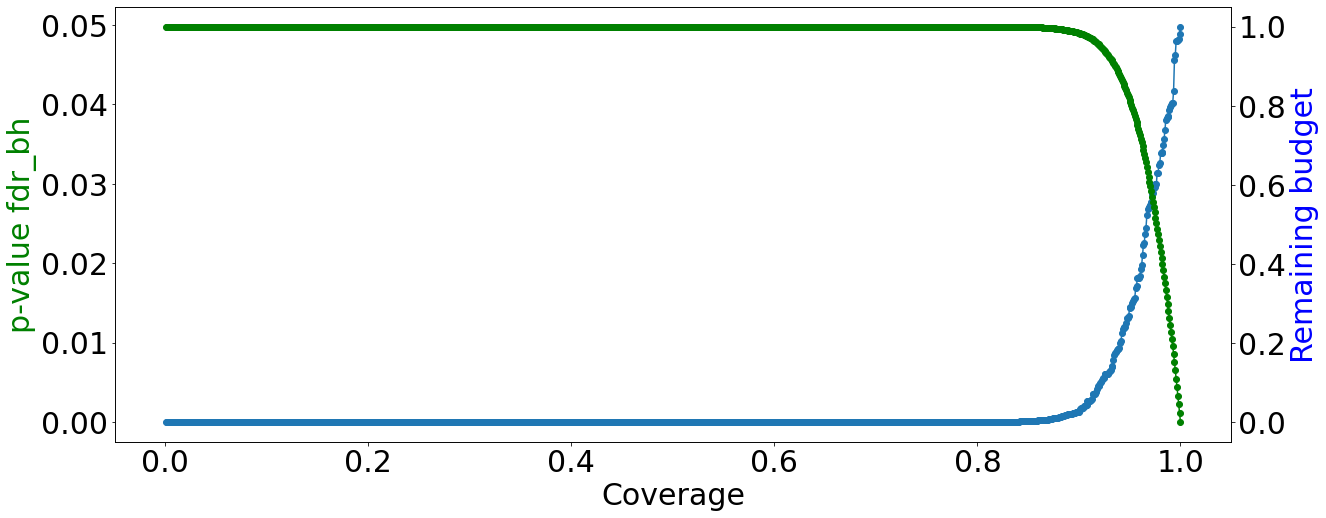

In [178]:


ax1 = plot_data[plot_column1].plot(figsize=(20,8),marker="o")
ax2 = ax1.twinx()
plot_data[plot_column2].plot(ax=ax2,figsize=(20,8),marker="o",color="green")


ax1.set_xlabel('Coverage')
ax1.set_ylabel(corrected_err_column, color='g')
ax2.set_ylabel('Remaining budget', color='b')

plt.show()



<AxesSubplot:xlabel='coverage'>

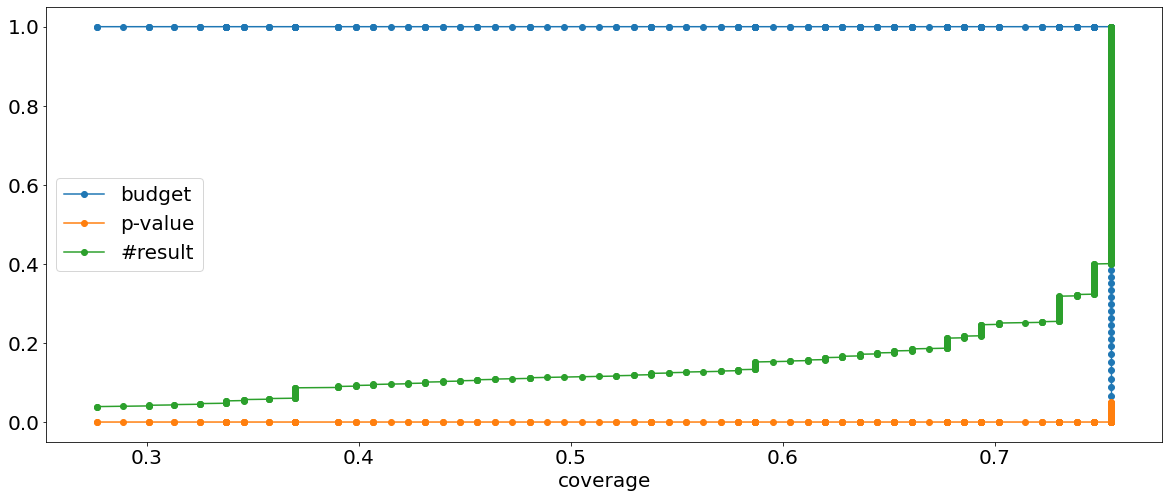

In [158]:
plot_column = "coverage"
plot_data = result[["budget","coverage",corrected_err_column,"#result"]].set_index(plot_column).sort_index()
plot_data = plot_data[plot_data[corrected_err_column]>0]
plot_data.plot(figsize=(20,8),marker="o")

In [71]:
result[corrected_err_column].cumsum().max()

2.21163414811329

In [55]:
result[corrected_err_column].cumsum().max()

2.21163414811329

In [24]:
# a,b = genxerate_stats()
# a

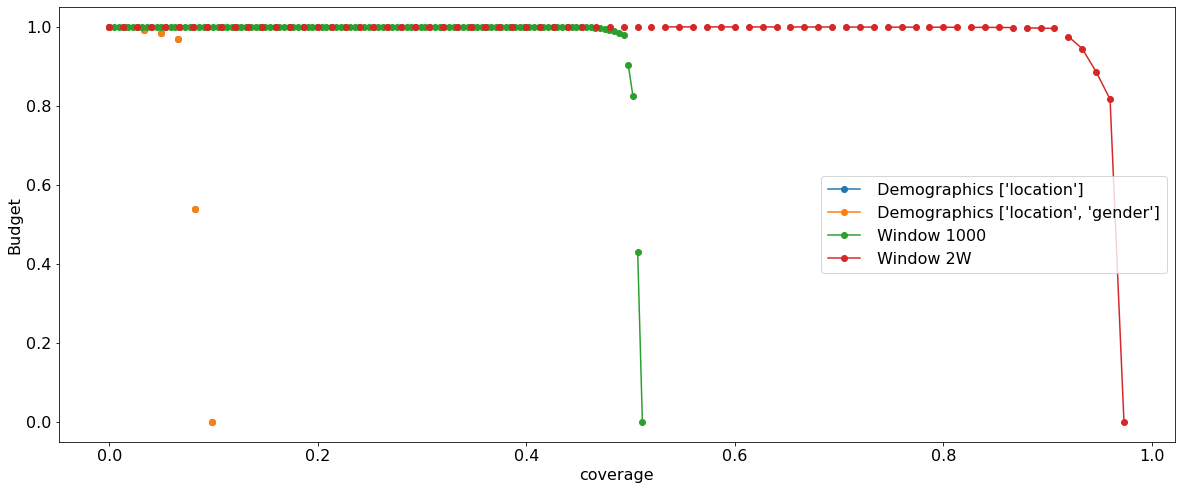

In [406]:
d = b.set_index("coverage").sort_index()
d = d[[i for i in d.columns if "pivot: D" in i]]
d.columns = [i.split("segmentation:")[1] for i in d.columns]
ax = ((d-d.min())/(d.max()-d.min())).plot.line(figsize=(20,8),marker="o")
plt.ylabel("Budget")
plt.show()
((d-d.min())/(d.max()-d.min())).to_csv("plot1.csv")

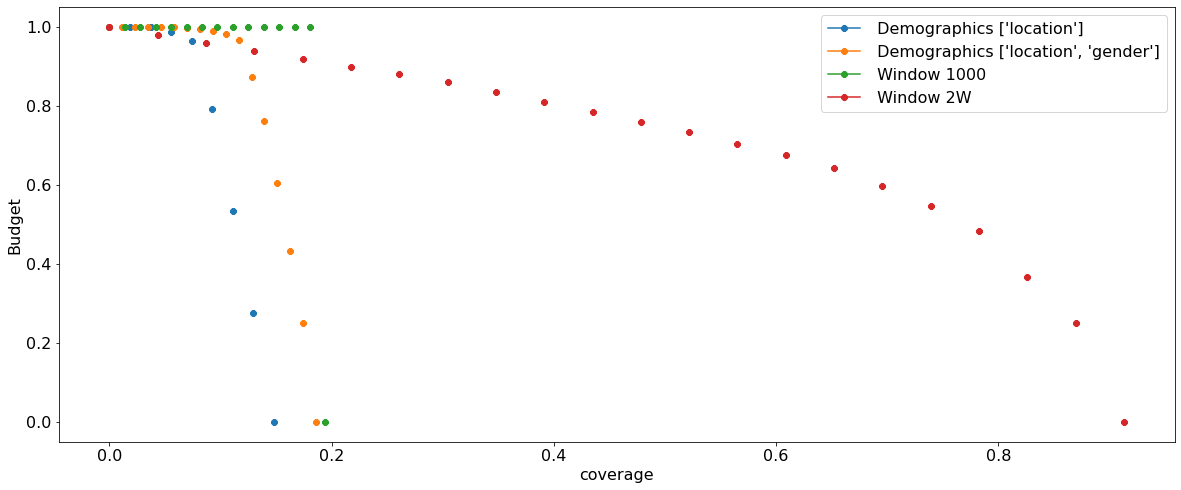

In [405]:
d = b.set_index("coverage").sort_index()
d = d[[i for i in d.columns if "pivot: P" in i]]
d.columns = [i.split("segmentation:")[1] for i in d.columns]
ax = ((d-d.min())/(d.max()-d.min())).plot.line(figsize=(20,8),marker="8")
plt.ylabel("Budget")
plt.show()
((d-d.min())/(d.max()-d.min())).to_csv("plot2.csv")

In [ ]:
d = b.set_index("coverage").sort_index()
d = d[[i for i in d.columns if "pivot: D" in i]]
d.columns = [i.split("segmentation:")[1] for i in d.columns]

ax = ((d-d.min())/(d.max()-d.min())).plot.line(figsize=(20,8),marker="o")
plt.ylabel("Budget")
plt.show()


In [2]:
b

NameError: name 'b' is not defined

In [331]:
result = pd.read_csv(files[2],index_col=0)

In [332]:
corrected_err_column

'p-value fdr_bh'

In [333]:
result
a = multipletests(result["p-value"],method=error_arg)
result[corrected_err_column] =  a[1]
budget = result["p-value fdr_bh"].sum()

result = result.set_index(["p-value fdr_bh", "e"]).sort_index()
index = result.index
for i in index:
    result.loc[i,"budget"] = budget - result.loc[:i,'p-value'].sum()
result

e_µ  e_std  \
p-value fdr_bh     e                                                      
0.0                2017-02-28 00:00:00-2019-12-30 00:00:00  57.3  27.04   
                   2017-02-28 00:00:00-2019-12-30 00:00:00 71.63  32.12   
                   2017-02-28 00:00:00-2019-12-30 00:00:00  57.3  27.04   
                   2017-02-28 00:00:00-2019-12-30 00:00:00  57.3  27.04   
                   2017-02-28 00:00:00-2019-12-30 00:00:00  57.3  27.04   
...                                                          ...    ...   
0.99216747428684   2017-03-08 00:00:00-2019-01-29 00:00:00  0.05   0.37   
                   2017-07-20 00:00:00-2019-11-06 00:00:00  0.04   0.25   
                   2018-07-04 00:00:00-2019-09-03 00:00:00   0.0   0.07   
0.9937893700636616 2017-04-25 00:00:00-2019-12-23 00:00:00  0.13    0.6   
0.9970155185918146 2017-05-04 00:00:00-2018-07-18 00:00:00  0.01   0.08   

                                                            e_size  \
p-value fdr_bh     e                                                 
0.0                2017-02-28 00:00:00-2019-12-30 00:00:00   59364   
                   2017-02-28 00:00:00-2019-12-30 00:00:00   74204   
                   2017-02-28 00:00:00-2019-12-30 00:00:00   59364   
                   2017-02-28 00:00:00-2019-12-30 00:00:00   59364   
                   2017-02-28 00:00:00-2019-12-30 00:00:00   59364   
...                                                            ...   
0.99216747428684   2017-03-08 00:00:00-2019-01-29 00:00:00      34   
                   2017-07-20 00:00:00-2019-11-06 00:00:00      31   
                   2018-07-04 00:00:00-2019-09-03 00:00:00       2   
0.9937893700636616 2017-04-25 00:00:00-2019-12-23 00:00:00     125   
0.9970155185918146 2017-05-04 00:00:00-2018-07-18 00:00:00       3   

                                                                                                  h  \
p-value fdr_bh     e                                                                                  
0.0                2017-02-28 00:00:00-2019-12-30 00:00:00  2017-04-06 00:00:00-2019-11-26 00:00:00   
                   2017-02-28 00:00:00-2019-12-30 00:00:00  2017-07-02 00:00:00-2019-07-26 00:00:00   
                   2017-02-28 00:00:00-2019-12-30 00:00:00  2017-11-30 00:00:00-2019-08-29 00:00:00   
                   2017-02-28 00:00:00-2019-12-30 00:00:00  2018-02-28 00:00:00-2019-07-16 00:00:00   
                   2017-02-28 00:00:00-2019-12-30 00:00:00  2017-03-16 00:00:00-2019-11-04 00:00:00   
...                                                                                             ...   
0.99216747428684   2017-03-08 00:00:00-2019-01-29 00:00:00  2017-03-16 00:00:00-2019-11-04 00:00:00   
                   2017-07-20 00:00:00-2019-11-06 00:00:00  2018-01-30 00:00:00-2018-07-12 00:00:00   
                   2018-07-04 00:00:00-2019-09-03 00:00:00  2017-07-02 00:00:00-2019-07-26 00:00:00   
0.9937893700636616 2017-04-25 00:00:00-2019-12-23 00:00:00  2018-08-03 00:00:00-2019-07-12 00:00:00   
0.9970155185918146 2017-05-04 00:00:00-2018-07-18 00:00:00  2017-07-02 00:00:00-2019-07-04 00:00:00   

                                                            h_µ  h_std  \
p-value fdr_bh     e                                                     
0.0                2017-02-28 00:00:00-2019-12-30 00:00:00 0.02   0.17   
                   2017-02-28 00:00:00-2019-12-30 00:00:00 0.03   0.34   
                   2017-02-28 00:00:00-2019-12-30 00:00:00 0.01   0.13   
                   2017-02-28 00:00:00-2019-12-30 00:00:00 0.01    0.1   
                   2017-02-28 00:00:00-2019-12-30 00:00:00 0.02   0.16   
...                                                         ...    ...   
0.99216747428684   2017-03-08 00:00:00-2019-01-29 00:00:00 0.02   0.16   
                   2017-07-20 00:00:00-2019-11-06 00:00:00 0.01   0.11   
                   2018-07-04 00:00:00-2019-09-03 00:00:00 0.03   0.34   
0.9937893700636616 2

In [ ]:
r = "e"
result = result.set_index([corrected_err_column, r]).sort_index()

## Remove duplicates in index
if not local:
    result = result[~result.index.get_level_values(1).duplicated(keep="first")]
result["p-value"] = result.index.get_level_values(0)

# Compute budget
def compute_budget(result, budget):


compute_budget(result, budget)

# coverage
result["coverage"] = 1
if local:
    result.loc[result.index.get_level_values(1).duplicated(), "coverage"] = 1
result["coverage"] = result["coverage"].cumsum() / result["#e"].unique()[0]

# plot
plot_data = result[result["budget"] >= 0].reset_index()[["coverage", "budget"]]
plot_data.loc[len(plot_data)] = [0, budget]
plot_data = plot_data.sort_values("coverage")
if plot:
    ax = plot_data.plot.line(x="coverage", y="budget", title=title, figsize=(20, 8))
return plot_data



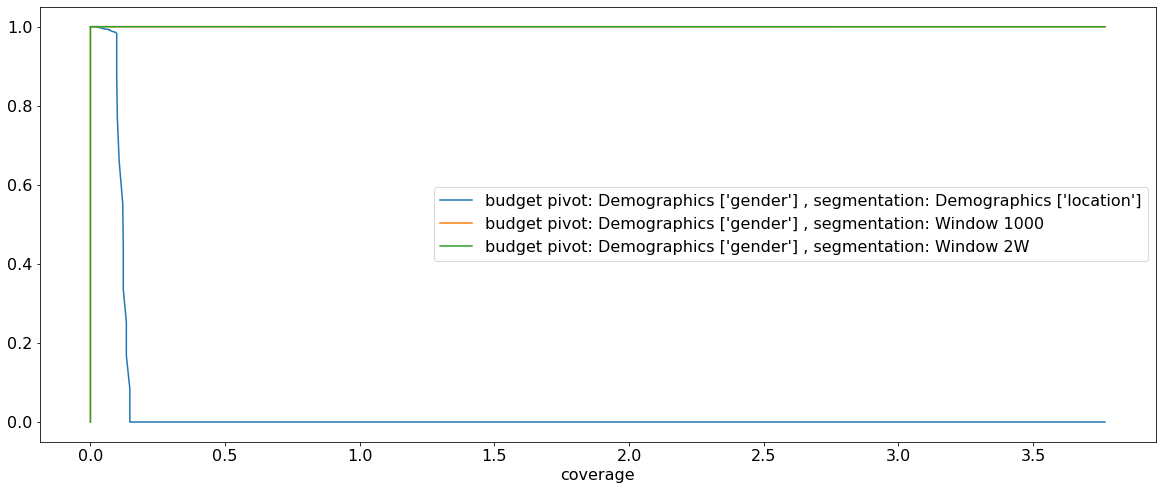

In [248]:
pd.set_option('display.float_format', str)
plt.rcParams["font.size"] = "16"


columns = ["coverage"]+[i for i in plots.columns[1:] if any(ii in i for ii in ["100","2W","location']"])]

d = plots[columns].set_index("coverage").sort_index().interpolate().fillna(1)

ax = ((d-d.min())/(d.max()-d.min())).plot(figsize=(20,8))
title="Budget consumption of behavioral pivot"


In [225]:
(d/d.max()).dropna().to_csv("data1.csv")

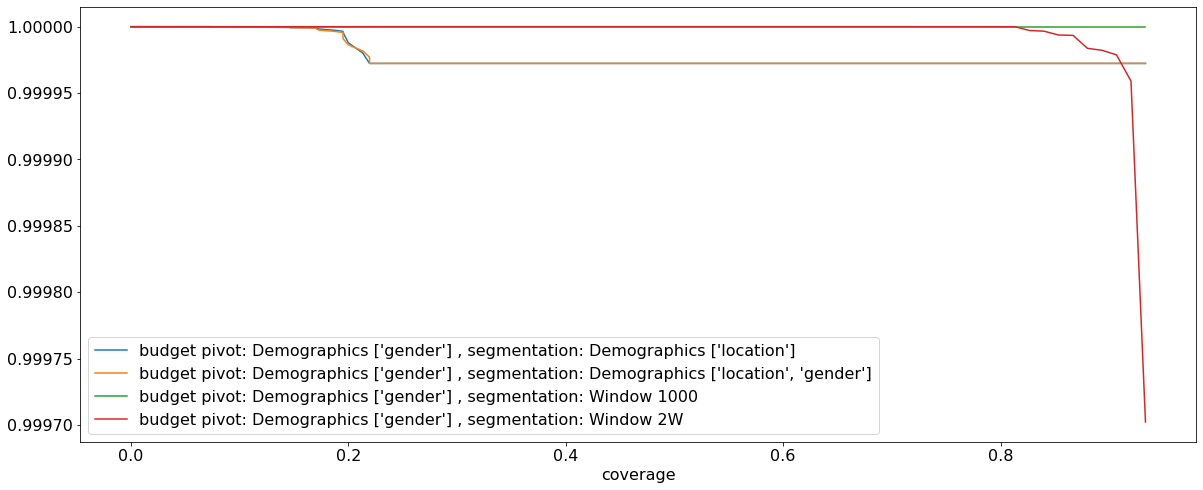

In [226]:
pd.set_option('display.float_format', str)
plt.rcParams["font.size"] = "16"
columns =["coverage"]+[ii for ii in plots.columns if "pivot: D" in ii  ]
d = plots[columns].set_index("coverage").sort_index().interpolate()
ax = (d/d.max()).dropna().plot(figsize=(20,8))
title="Budget consumption of behavioral pivot"


budget experiments/results/pivot: demographics ['gender'] , segmentation: temporal 100


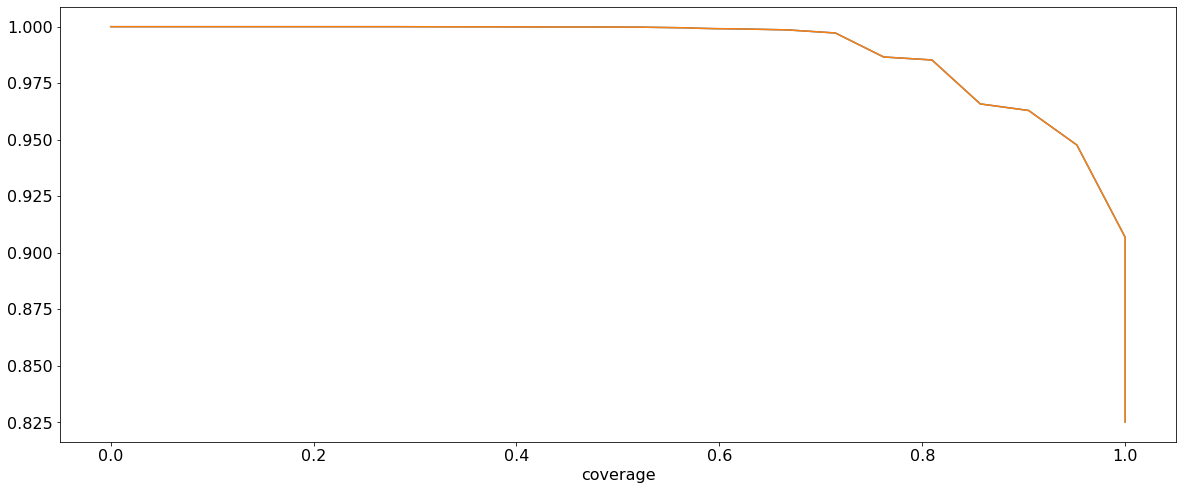

In [346]:
a = d/d.max()
ax = a[a.columns[0]].dropna().plot(figsize=(20,8))
for i in a.columns[0:1]:
    print(i)
    a[i].dropna().plot(ax=ax)

In [347]:
i

"budget experiments/results/pivot: demographics ['gender'] , segmentation: temporal 100"

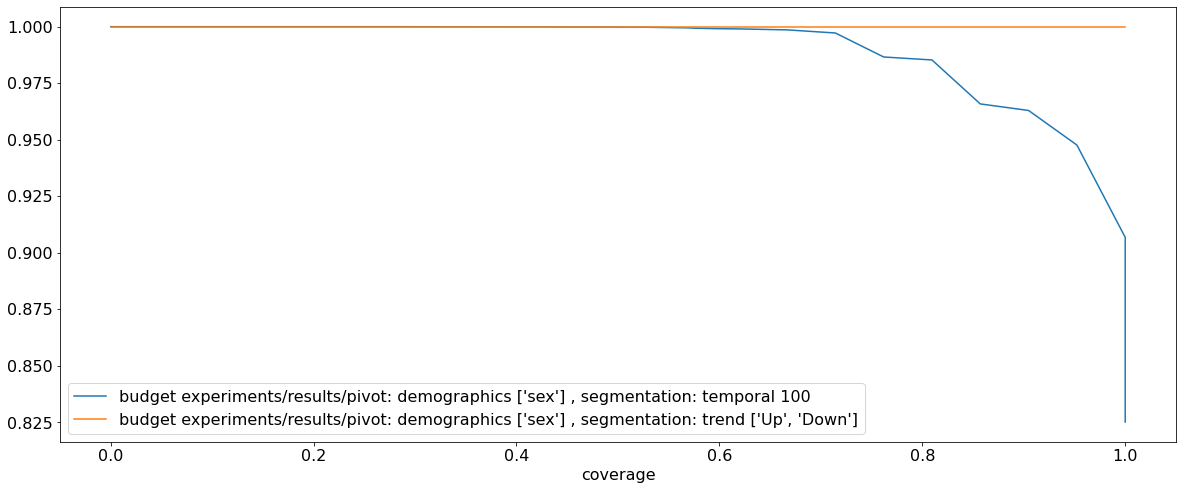

In [348]:
columns =["coverage"]+[ii for ii in plots.columns if "pivot: demog" in ii and "500" not in ii and '400' not in ii]
d = plots[sorted(columns)].set_index("coverage").sort_index().interpolate()
ax = (d/d.max()).plot(figsize=(20,8))
title="Budget consumption of demographic pivot"

In [121]:
columns =["coverage"]+[ii for ii in plots.columns if "pivot: promo" in ii and "500" not in ii and '400' not in ii and "gender" not in ii and "20" not in ii]
d = plots[columns].set_index("coverage").sort_index().interpolate()
ax = (d/d.max()).plot(figsize=(20,8))
title="Budget consumption of promotions pivot"


In [16]:
experiment_name(pivot_type,pivot_arg,segmentation_type,segmentation_arg)

"pivot: behavioral ['Up', 'Other'] , segmentation: temporal W"

In [24]:
r =[]
for i in range(0,len(res)):
    r.append((*res[i][1].split(" , "),res[i][0]["p-value (FDR)"].max(),res[i][0].shape[0],res[i][0]["p-value (FDR)"].max()*res[i][0].shape[0]))
pd.DataFrame(r,columns = ["pivot","segmentation","max(ap-val)","#result","#results * max(ap-val)"])

,pivot,segmentation,max(ap-val),#result,#results * max(ap-val)


In [222]:
result = pd.read_csv("experiments/results/pivot: Demographics ['gender'] , segmentation: Window 1000.csv",index_col=0)
a = multipletests(result["p-value"],method=error_arg)
result[corrected_err_column] =  a[1]
result = result[a[0]]
result

,e,e_size,h,h_size,t-value,p-value,e_normal,h_normal,chi-squared test,Dh_size,De_size,#h,#e,segmentation,pivot,test,p-value (FDR),p-value fdr_bh
2132,"1000, [2017-03-10,2019-10-25]",1000,"1000, [2017-03-05,2019-12-30]",1000,16.41551241875773,2.0892178520039963e-55,False,False,2.8542178086372024e-45,29663,220545,30,221,Window_1000,Demographics_['gender'],mean,1.3851514358786495e-51,1.3851514358786495e-51
2141,"1000, [2017-03-10,2019-10-25]",1000,"1000, [2017-03-09,2019-12-16]",1000,16.23956048222697,7.713056431573314e-54,False,False,1.5102738815478304e-07,29663,220545,30,221,Window_1000,Demographics_['gender'],mean,2.556878207066554e-50,2.5568782070665536e-50
2157,"1000, [2017-03-10,2019-10-25]",1000,"1000, [2017-03-10,2019-12-28]",1000,16.14591880245698,1.938957810327743e-53,False,False,3.5091608803109026e-07,29663,220545,30,221,Window_1000,Demographics_['gender'],mean,4.285096760824312e-50,4.285096760824312e-50
3637,"1000, [2017-03-05,2019-12-30]",1000,"1000, [2017-03-10,2019-12-30]",1000,-16.113911261761718,4.1534049253674014e-53,False,False,0.3538628349545289,29663,220545,30,221,Window_1000,Demographics_['gender'],mean,6.884268663796469e-50,6.884268663796467e-50
1147,"1000, [2017-03-04,2019-12-26]",1000,"1000, [2017-03-10,2019-12-30]",1000,-15.998121929320751,5.825365450111024e-53,False,False,4.522242031724327e-42,29663,220545,30,221,Window_1000,Demographics_['gender'],mean,7.724434586847218e-50,7.724434586847218e-50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2988,"1000, [2017-03-08,2019-12-30]",1000,"1000, [2017-03-07,2019-12-26]",1000,2.0953760220965822,0.0362614520101289,False,False,0.6260950673387191,29663,220545,30,221,Window_1000,Demographics_['gender'],mean,0.0487555114230693,0.048755511423069275
2482,"1000, [2017-03-04,2019-12-27]",1000,"1000, [2017-03-08,2019-12-16]",1000,2.0892411775895376,0.0368098720461762,False,False,1.0,29663,220545,30,221,Window_1000,Demographics_['gender'],mean,0.0494828571910277,0.049482857191027615
2782,"1000, [2017-03-08,2019-12-30]",1000,"1000, [2017-03-08,2019-12-16]",1000,2.089100818645951,0.0368227205344008,False,False,0.2422792342743703,29663,220545,30,221,Window_1000,Demographics_['gender'],mean,0.0494900946975629,0.0494900946975628
1110,"1000, [2017-03-04,2019-12-26]",1000,"1000, [2017-03-09,2019-12-30]",1000,-2.0874118876146928,0.03697463416833,False,False,9.534701775957064e-23,29663,220545,30,221,Window_1000,Demographics_['gender'],mean,0.0496841962983438,0.04968419629834372


In [213]:
i

"experiments/results/pivot: Demographics ['gender'] , segmentation: Window 2W.csv"

In [110]:
res = [i for i in res_copy.copy() if "pivot: de" in i[1]]
plot_results(res)

In [78]:
import numpy as np
import matplotlib.pyplot as plt

res = [i for i in res_copy.copy() if "Up"in i[1]]
a,b = res[0]

plot_data = compute_result_budget(a,a["p-value"].max()*a.shape[0],plot=False,title=b)
plot_data.columns = ["coverage",b]
ax = plot_data.set_index("coverage").plot(figsize=(20,8))

for a,b in res:
    plot_data = compute_result_budget(a,a["p-value"].shape[0]*a["p-value"].max(),plot=False,title=b)
    plot_data.columns = ["coverage",b]
    plot_data.set_index("coverage").plot(ax=ax)
plt.show()


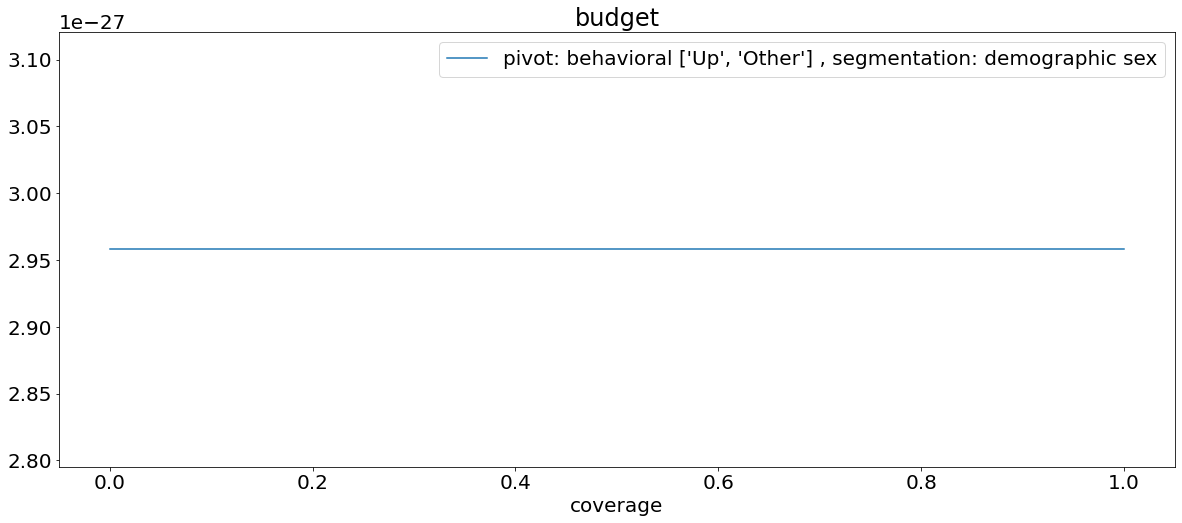

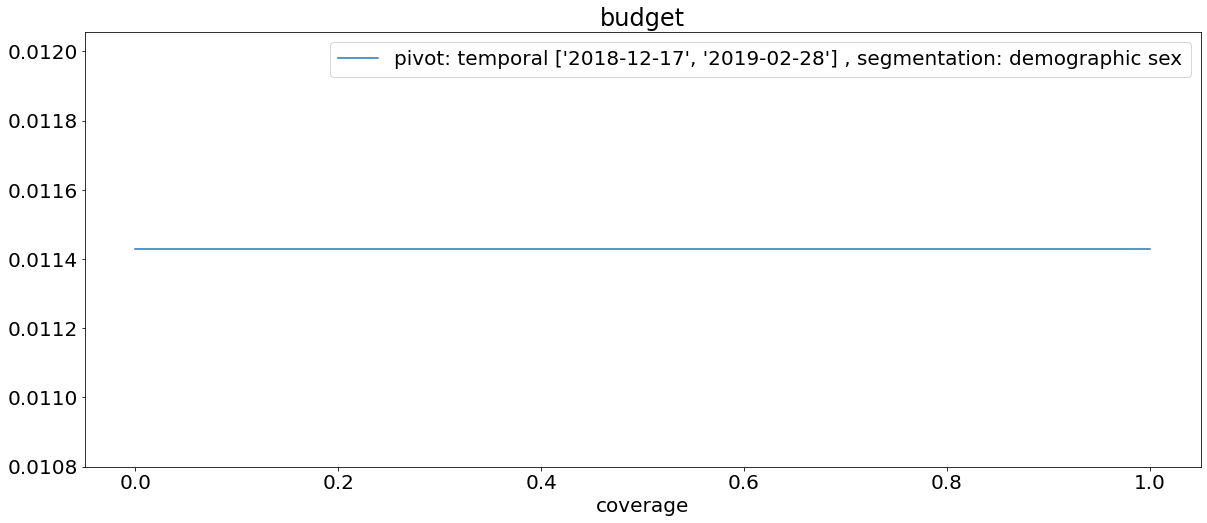

In [16]:
plt.rcParams["font.size"] = "20"
for a,b in res:
    if "temporal 400" in b:
        continue
    plot_data = compute_result_budget(a,a["p-value"].sum(),plot=False,title=b)
    plot_data.columns = ["coverage",b]
    plot_data.set_index("coverage").plot(title="budget",figsize=(20,8))
    plt.show()

In [220]:
def compute_result_budget(result,budget,plot=False,title=None):
    r = [i for i in result.columns if "r_" in i ][0]
    result = result.set_index(["p-value (FDR)",r]).sort_index()


    ## Remove duplicates in index 
    result = result[~result.index.get_level_values(1).duplicated(keep="first")]
    result["p-value"] = result.index.get_level_values(0)

    # Compute budget 
    def compute_budget(result,budget):
        index = result.index
        for i in index:
            result.loc[i,"budget"] = budget - result.loc[:i].shape[0] * result.loc[:i,'p-value'].max()
    compute_budget(result,budget)
    # coverage 
    result["coverage"] = 1
    result["coverage"] = result["coverage"].cumsum() /result["#r"].unique()[0] 


    # plot 
    plot_data = result[result["budget"]>=0].reset_index()[["coverage","budget"]]
    plot_data.loc[len(plot_data)]=[0,budget]
    plot_data = plot_data.sort_values("coverage")
    if plot:
        ax = plot_data.plot.line(x="coverage",y="budget",title=title,figsize=(20,8))
    return plot_data


In [13]:
pd.read_csv("results_example.csv",index_col=0)

,t_>2019-02-28,t_size,r_<2018-12-17,r_size,t-value,p-value,R_size,T_size,#r,#t,segmentation,pivot,test,p-value (FDR)
821,"200, [2019-02-28,2019-11-08]",200,"200, [2017-04-05,2018-12-13]",200,7.313447,5.908487e-13,9395,5326,47,27,temporal_200,"temporal_['2018-12-17', '2019-02-28']",mean,1.947615e-10
838,"200, [2019-02-28,2019-11-08]",200,"200, [2017-05-11,2018-12-14]",200,7.282992,7.554008e-13,9395,5326,47,27,temporal_200,"temporal_['2018-12-17', '2019-02-28']",mean,1.947615e-10
816,"200, [2019-02-28,2019-11-08]",200,"200, [2017-05-05,2018-12-11]",200,7.275560,7.932785e-13,9395,5326,47,27,temporal_200,"temporal_['2018-12-17', '2019-02-28']",mean,1.947615e-10
827,"200, [2019-02-28,2019-11-08]",200,"200, [2017-05-11,2018-12-17]",200,7.262562,8.684162e-13,9395,5326,47,27,temporal_200,"temporal_['2018-12-17', '2019-02-28']",mean,1.947615e-10
845,"200, [2019-02-28,2019-11-08]",200,"195, [2017-06-02,2018-12-17]",195,7.265274,8.706355e-13,9395,5326,47,27,temporal_200,"temporal_['2018-12-17', '2019-02-28']",mean,1.947615e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,"200, [2019-03-04,2019-12-30]",200,"200, [2017-10-05,2018-12-14]",200,2.776233,5.638996e-03,9395,5326,47,27,temporal_200,"temporal_['2018-12-17', '2019-02-28']",mean,5.875112e-03
105,"200, [2019-02-28,2019-12-30]",200,"200, [2017-10-05,2018-12-14]",200,2.772189,5.708022e-03,9395,5326,47,27,temporal_200,"temporal_['2018-12-17', '2019-02-28']",mean,5.942149e-03
1092,"200, [2019-02-28,2019-12-30]",200,"200, [2017-10-05,2018-12-14]",200,2.714986,6.782334e-03,9395,5326,47,27,temporal_200,"temporal_['2018-12-17', '2019-02-28']",mean,7.054739e-03
904,"200, [2019-02-28,2019-12-26]",200,"200, [2017-10-05,2018-12-14]",200,2.700758,7.077229e-03,9395,5326,47,27,temporal_200,"temporal_['2018-12-17', '2019-02-28']",mean,7.355450e-03


In [10]:
!ls *.csv

 all_experiments.csv
''\''_'\''.join(str(i) for i in [pivot_type,pivot_arg,segmentation_type,segmentation_arg,test_type,test_arg,error_correction_test,threshold,plot]).csv'
 partitionning_cumulative_0.1.csv
 partitionning_cumulative_0.2.csv
 partitionning_cumulative_0.35.csv
 partitionning_cumulative_0.5.csv
 partitionning_cumulative_0.csv
 results_example.csv
 starting_data.csv
 temporal_segmentaiton_results.csv
 test.csv


In [72]:

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

X = np.linspace(0,1,1000)
Y = np.cos(X*20)

ax1.plot(X,Y)
ax1.set_xlabel(r"Original x-axis: $X$")

new_tick_locations = np.array([.2, .5, .9])

def tick_function(X):
    V = 1/(1+X)
    return ["%.3f" % z for z in V]

ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations))
ax2.set_xlabel(r"Modified x-axis: $1/(1+X)$")
plt.show()

In [ ]:
df_stats = pd.DataFrame(res)
df_stats.columns = ["pivot",'pivot_arg','segmentation','segmentation_arg','agg','','error control','alpha','#results',"sum ap-value",'r_coverage','t_coverage'] 
df_stats

In [20]:
'_'.join(str(i) for i in [pivot_type,pivot_arg,segmentation_type,segmentation_arg,test_type,test_arg,error_correction_test,threshold,plot])

"demographics_['gender']_temporal_Y_mean__FDR_0.05_False"

In [26]:
print(df_stats.to_latex(index=False))

\begin{tabular}{lllllllrrrrr}
\toprule
       pivot &         pivot\_arg & segmentation & segmentation\_arg &  agg & {} & error control &  alpha &  \#results &  sum ap-value &  r\_coverage &  t\_coverage \\
\midrule
demographics & ['gender'] (r=F,t=M) &     temporal &                W & mean & {} &           FDR &   0.05 &     21904 &  1.942374e+02 &    0.993289 &    0.993289 \\
demographics & ['gender'] (r=F,t=M) &     temporal &               2W & mean & {} &           FDR &   0.05 &      5625 &  5.109631e+01 &    1.000000 &    1.000000 \\
demographics & ['gender'] (r=F,t=M) &     temporal &               3W & mean & {} &           FDR &   0.05 &      2500 &  3.000554e+01 &    0.980392 &    0.980392 \\
demographics & ['gender'] (r=F,t=M) &     temporal &                M & mean & {} &           FDR &   0.05 &      1156 &  2.267783e-06 &    1.000000 &    0.971429 \\
demographics & ['gender'] (r=F,t=M) &     temporal &               3M & mean & {} &           FDR &   0.05 &       144 &

In [30]:
df_stats[["r_coverage","t_coverage"]].apply(lambda x : f'{x}')

0    r_coverage    0.993289\nt_coverage    0.993289...
1    r_coverage    1.0\nt_coverage    1.0\nName: 1,...
2    r_coverage    0.980392\nt_coverage    0.980392...
3    r_coverage    1.000000\nt_coverage    0.971429...
4    r_coverage    1.000000\nt_coverage    0.923077...
5    r_coverage    1.000000\nt_coverage    0.857143...
6    r_coverage    1.0\nt_coverage    0.8\nName: 6,...
7    r_coverage    1.0\nt_coverage    1.0\nName: 7,...
dtype: object

In [3]:
temporal_pivot_argument = [df.index[300],df.index[500]]
reference_set,test_set = pivot_handler.pivot("temporal",df,temporal_pivot_argument)
print(reference_set.shape,test_set.shape)

(1371891, 9) (482113, 9)


In [9]:
isinstance(test_set, pd.DataFrame)

True

In [4]:
temporal_pivot_argument 

[Timestamp('2017-12-09 00:00:00'), Timestamp('2017-11-16 00:00:00')]

In [14]:
splitter = CumulativeSegmentsSplitter()

TypeError: 'CumulativeSegmentsSplitter' object is not callable

In [10]:
import numpy as np

In [12]:
np.diff([1,2,3],[1,2])

TypeError: '<' not supported between instances of 'list' and 'int'

In [50]:
def a(b=[]):
    b.append(123)
    print(b)

a()
a()
a()

[123]
[123, 123]
[123, 123, 123]


In [52]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

/home/abdelouahab/.virtualenvs/SSQ/bin/python
3.8.5 (default, Jul 28 2020, 12:59:40) 
[GCC 9.3.0]
sys.version_info(major=3, minor=8, micro=5, releaselevel='final', serial=0)


In [49]:
a()

[123, 123, 123]
